In [2]:
from folium.plugins import MarkerCluster
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import textwrap
import folium
import random
import os



In [4]:
chunk_size = 100000  # Adjust based on available memory
all_data_frame = {
    "raw_data_file_frame": "",
    "cleaned_data_file_frame":"",
    "fl_data_frame": "",
    "ca_data_frame":"",
    "ny_data_frame":""
}

raw_file_path = r"..\data\US_Accidents_March23.csv"
fl_data_file = r"..\data\processed_data_file\data_by_state\FL_org.csv"
ca_data_file = r"..\data\processed_data_file\data_by_state\CA_org.csv"
va_data_file = r"..\data\processed_data_file\data_by_state\VA_org.csv"
ny_data_file = r"..\data\processed_data_file\data_by_state\NY_org.csv"
all_data_file = r"..data\processed_data_file\raw_cleaned_data\cleaned_all_state_data.csv"
output_dir_raw_clean_data = r"..\data\processed_data_file\raw_cleaned_data"
output_dir_cleaned_data_by_state = r"..\data\processed_data_file\data_by_state"

In [5]:
USA_2023_POPULATION_DATA = {
    "State": [
        "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY",
        "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH",
        "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
    ],
    "Population": [
        3977628, 557899, 5848310, 2362124, 30519524, 4662926, 2894190, 819952, 552380, 18229883,
        8490546, 1141525, 1497384, 9844167, 5274945, 2476882, 2246209, 3509259, 3506600, 1146670,
        4818337, 5659598, 7925350, 4436981, 2259864, 4821686, 897161, 1497381, 2508220, 1150004,
        7280551, 1663024, 15611308, 8498868, 599192, 9207681, 3087217, 3401528, 10332678, 892124,
        4229354, 697420, 5555761, 22942176, 2484582, 532828, 6834154, 6164810, 1417859, 4661826, 454508
    ]
}
usa_2023_population_age_18_and_up_data_frame = pd.DataFrame(USA_2023_POPULATION_DATA)

In [7]:
""""
This section is used to load the raw data frame, process the data and save the processed data based on state. 
This section also initializes the data frame objects, which will be used in further analysis
"""

def read_large_csv(file_path, chunk_size):
    """Reads a large CSV file in chunks and returns a generator of chunks."""
    return pd.read_csv(file_path, chunksize=chunk_size, low_memory=False)


def process_large_csv(file_path, chunk_size=100000):
    """Processes the large CSV file and returns the cleaned DataFrame."""
    df_combined = pd.DataFrame()

    for chunk in read_large_csv(file_path, chunk_size):
        df_combined = pd.concat([df_combined, chunk], ignore_index=True)

    return df_combined

def init_state_data_frames():
    print("*** initialize data frame for CA,FL and NY ******* ")
    all_data_frame["fl_data_frame"] = process_large_csv(fl_data_file)
    all_data_frame["ca_data_frame"] = process_large_csv(ca_data_file)
    all_data_frame["ny_data_frame"] = process_large_csv(ny_data_file)

def drop_columns(data_frame):
    cols_to_drop = ['ID', 'Source', 'End_Lat', 'End_Lng', 'Distance(mi)', 
                    'Description', 'Airport_Code', 'Pressure(in)', 
                    'Wind_Direction', 'Precipitation(in)', 
                    'Amenity','Give_Way', 'No_Exit', 'Traffic_Calming', 
                    'Turning_Loop', 'Nautical_Twilight', 'Astronomical_Twilight',
                    'Civil_Twilight','Airport_Code','Sunrise_Sunset', 'Wind_Chill(F)'
                    ]
    return data_frame.drop(cols_to_drop, axis=1)


def split_and_save_by_state(data_frame):
    """Splits data by state and saves it into separate CSV files."""
    os.makedirs(output_dir_cleaned_data_by_state, exist_ok=True)

    for state, state_df in data_frame.groupby("State"):
        if (state == 'FL' or state == 'CA' or state == 'VA' or state == 'NY') :
            state_file = os.path.join(output_dir_cleaned_data_by_state, f"{state}_org.csv")
            state_df.to_csv(state_file, index=False)
    print(f"Data saved for FA, CA, VA, NY \n ")


def save_cleaned_raw_data(data_frame):
    os.makedirs(output_dir_raw_clean_data, exist_ok=True)
    filePath = os.path.join(output_dir_raw_clean_data, "cleaned_all_state_data.csv")
    data_frame.to_csv(filePath, index=False)
    print(f"Saved Cleaned all state Data  \n ")


def data_preprocessing_and_cleanup (data_frame):
    print(" *****************  Starting Data Preprocessing and Cleanup  **************")
    data_frame = data_frame[data_frame["Source"].str.lower() == "source1"]
    data_frame = drop_columns(data_frame)

    missing_data = pd.DataFrame(data_frame.isnull().sum()).reset_index()
    missing_data.columns = ['Feature', 'Missing_Percent(%)']
    missing_data['Missing_Percent(%)'] = missing_data['Missing_Percent(%)'].apply(lambda x: x / data_frame.shape[0] * 100)
    missing_data.loc[missing_data['Missing_Percent(%)']>0,:]
    data_frame = data_frame.dropna(subset=['City','Zipcode','Street',
                        'Zipcode','County','Timezone','Weather_Timestamp'])

    data_frame.dropna(inplace = True)
    return data_frame


def print_basic_summary(data_frame, state=''):
    print(f"***  Printing Basic Data Frame Summary: {state} ****")
    print(" \n Unique Source: ", data_frame['Source'].unique())
    print(" \n Unique State: ", data_frame['State'].unique())
    print("\n The shape of data frame is:",(data_frame.shape))
    print("\n Data frame info: \n",data_frame.info())


def print_summary(data_frame, state=''):
    print(f"***  Printing Data Frame Summary: {state} **** \n")
    print(f"{data_frame.info()}")
    print(f"***  Data Frame description **** \n")
    print(data_frame.describe(include="all"))
    print("\n The shape of data is:",(data_frame.shape))
    print("\n Top 3 records \n")
    display(data_frame.head(3))



In [8]:
all_data_frame["raw_data_file_frame"] = process_large_csv(raw_file_path)
print_basic_summary(all_data_frame["raw_data_file_frame"] , state='Raw Data')
all_data_frame["cleaned_data_file_frame"] = data_preprocessing_and_cleanup (all_data_frame["raw_data_file_frame"])
print_summary(all_data_frame["cleaned_data_file_frame"], state='Cleaned Raw Data')
save_cleaned_raw_data(all_data_frame["cleaned_data_file_frame"])
split_and_save_by_state(all_data_frame["cleaned_data_file_frame"])
init_state_data_frames()


***  Printing Basic Data Frame Summary: Raw Data ****
 
 Unique Source:  ['Source2' 'Source3' 'Source1']
 
 Unique State:  ['OH' 'WV' 'CA' 'FL' 'GA' 'SC' 'NE' 'IA' 'IL' 'MO' 'WI' 'IN' 'MI' 'NJ'
 'NY' 'CT' 'MA' 'RI' 'NH' 'PA' 'KY' 'MD' 'VA' 'DC' 'DE' 'TX' 'WA' 'OR'
 'AL' 'NC' 'AZ' 'TN' 'LA' 'MN' 'CO' 'OK' 'NV' 'UT' 'KS' 'NM' 'AR' 'MS'
 'ME' 'VT' 'WY' 'ID' 'ND' 'MT' 'SD']

 The shape of data frame is: (7728394, 46)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 1

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Street,City,County,State,Zipcode,...,Wind_Speed(mph),Weather_Condition,Bump,Crossing,Junction,Railway,Roundabout,Station,Stop,Traffic_Signal
3402762,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,Outerbelt E,Dublin,Franklin,OH,43017,...,10.4,Light Rain,False,False,False,False,False,False,False,False
3402767,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,I-75 S,Cincinnati,Hamilton,OH,45217,...,10.4,Light Rain,False,False,False,False,False,False,False,False
3402768,2,2016-02-08 08:16:57,2016-02-08 14:16:57,39.063240,-84.032430,State Route 32,Williamsburg,Clermont,OH,45176,...,8.1,Overcast,False,False,False,False,False,False,False,True


Saved Cleaned all state Data  
 
Data saved for FA, CA, VA, NY 
 
*** initialize data frame for CA,FL and NY ******* 


# EDA US All State

#### USA Map based on accident count

In [9]:
def plot_us_map_accident_count(data_frame):
    state_counts = data_frame["State"].value_counts().reset_index()
    state_counts.columns = ["State", "Accidents"]

    fig = px.choropleth(
        state_counts, 
        locations="State", 
        locationmode="USA-states", 
        color="Accidents",
        color_continuous_scale="reds",
        title="Number of US Accidents for each State"
    )
    fig.update_layout(geo=dict(scope="usa"))
    fig.show()

plot_us_map_accident_count(all_data_frame["cleaned_data_file_frame"])


In [ ]:


def plot_histogram_weather_condition_vs_accident_count(data_frame, state=''):
    """Analyzes the state-wise accident count and plots a histogram."""
    weather_condition = data_frame["Weather_Condition"].value_counts()
    
    plt.figure(figsize=(25, 20))
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))   
    weather_condition.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.xlabel("Weather")
    plt.ylabel("Total Accidents")
    plt.title(f"Total Accidents by weather condition: {state}")
    plt.xticks(rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


def plot_histogram_top_20_city_accident_count(data_frame, state=""):

    # Get the top 20 cities with the highest number of accidents
    top_cities = data_frame["City"].value_counts().sort_values()[-20:].reset_index()
    top_cities.columns = ["city", "number_of_accidents"]

    # Plot the bar chart
    plt.figure(figsize=(20,7))
    sns.barplot(x="city", y="number_of_accidents", hue="city", data=top_cities, palette='Set2', legend=False)
    plt.title(f"TOP 20 CITIES WITH HIGHEST NUMBER OF ACCIDENTS - {state}", fontsize=20)
    plt.xticks(rotation=40)
    plt.show()


# accedent_data_frame
def plot_stacked_bar_chart_state_sev_population(accedent_data_frame, population_data_frame):

    # Count accidents per state per severity level
    severity_counts = accedent_data_frame.groupby(["State", "Severity"]).size().unstack(fill_value=0)
    
    # Merge with population data
    merged_df = population_data_frame.merge(severity_counts, on="State", how="left").fillna(0)
    
    # Define colors for severity levels
    severity_colors = {1: "#a6cee3", 2: "#1f78b4", 3: "#b2df8a", 4: "#33a02c"}

    # Plot stacked bar chart
    ax = merged_df.set_index("State")[sorted(severity_counts.columns)].plot(
        kind="bar", stacked=True, figsize=(14, 7), color=[severity_colors[s] for s in sorted(severity_counts.columns)]
    )

    # Labels and title
    plt.xlabel("State")
    plt.ylabel("Number of Accidents")
    plt.title("Accidents count vs State and Severity Level")
    plt.xticks(rotation=45, ha="right")
    
    # Add legend
    plt.legend(title="Severity Level", loc="upper right")

    # Show plot
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_bubble_chart(accedent_data_frame, population_data_frame):
    # Aggregate accident count and average severity per state
    accident_summary = accedent_data_frame.groupby("State").agg(
        Accidents=("State", "count"),
        Avg_Severity=("Severity", "mean")
    ).reset_index()

    # Merge with population data
    merged_df = pd.merge(accident_summary, population_data_frame, on="State")

    # Normalize population size for better bubble visualization
    pop_scaled = merged_df["Population"] / 50000  # Adjusting scale for better visibility

    # Create Bubble Chart
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        merged_df["Population"], 
        merged_df["Accidents"], 
        s=pop_scaled,  # Bubble size based on population
        c=merged_df["Avg_Severity"],  # Color based on severity
        cmap="Reds", 
        alpha=0.7,
        edgecolors="k"
    )

    # Add state labels on each bubble
    for i, row in merged_df.iterrows():
        plt.text(row["Population"], row["Accidents"], row["State"], fontsize=10, ha='center', va='center', color="black")

    # Add color bar for severity
    cbar = plt.colorbar(scatter)
    cbar.set_label("Average Severity (1=Low, 4=High)")

    # Labels and title
    plt.xlabel("State Population")
    plt.ylabel("Number of Accidents")
    plt.title("Bubble Chart of Accidents vs. Population (Scaled by Population & Colored by Severity)")

    # Grid for better readability
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show plot
    plt.show()


def plot_paginated_accident_percentage_improved(accident_data_frame, population_data_frame, states_per_page=4):

    # Aggregate accident count per state and severity
    accident_summary = accident_data_frame.groupby(["State", "Severity"]).size().unstack(fill_value=0)

    # Merge with population data
    merged_df = population_data_frame.merge(accident_summary, on="State", how="left").fillna(0)

    # Calculate accident percentage per severity level
    for severity in sorted(accident_summary.columns):
        merged_df[f"Severity_{severity}_Percentage"] = (merged_df[severity] / merged_df["Population"]) * 100

    # Sort states by population (descending)
    merged_df = merged_df.sort_values(by="Population", ascending=False)

    # Define severity colors
    severity_colors = {1: "#a6cee3", 2: "#1f78b4", 3: "#b2df8a", 4: "#33a02c"}

    # Paginate the states into batches
    total_states = len(merged_df)
    for start in range(0, total_states, states_per_page):
        end = min(start + states_per_page, total_states)
        subset_df = merged_df.iloc[start:end]

        # Determine subplot grid size
        num_states = len(subset_df)
        cols = 2  # Maximum 2 columns for better readability
        rows = int(np.ceil(num_states / cols))  # Auto-adjust row count

        # Adjust figure size dynamically
        fig_height = max(4, rows * 2.5)  # Ensure proper spacing
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, fig_height))
        axes = np.array(axes).reshape(-1)  # Flatten for easy indexing

        # Generate bar plots for each state
        for idx, row in enumerate(subset_df.itertuples()):
            state = row.State
            population = row.Population
            severity_percentages = [getattr(row, f"Severity_{s}_Percentage") for s in sorted(accident_summary.columns)]

            # Plot bars
            bars = axes[idx].bar(
                sorted(accident_summary.columns),
                severity_percentages,
                color=[severity_colors[s] for s in sorted(accident_summary.columns)]
            )

            # Adjust y-axis limits to ensure no overlap
            max_percentage = max(severity_percentages) if severity_percentages else 0
            axes[idx].set_ylim(0, max_percentage * 1.3)  # Add space above bars

            # Add title with population info, ensuring no overlap with bars
            axes[idx].text(0.5, 1.15, f"{state}\nPop: {population:,}", fontsize=10, fontweight="bold",
                           ha='center', va='top', transform=axes[idx].transAxes)

            axes[idx].set_xlabel("Severity Level")
            axes[idx].set_ylabel("Accident % of Population")
            axes[idx].set_xticks(sorted(accident_summary.columns))

            # Add percentage annotations on bars with dynamic vertical placement
            for bar, percent in zip(bars, severity_percentages):
                height_adjustment = max_percentage * 0.05  # Adjust placement dynamically
                axes[idx].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + height_adjustment,
                               f"{percent:.2f}%", ha='center', va='bottom', fontsize=8, color="black")

        # Hide any unused subplots (if fewer states than grid size)
        for i in range(idx + 1, len(axes)):
            fig.delaxes(axes[i])

        # Show the current page of subplots
        plt.suptitle(f"Accident Percentage by Severity Level per State (Sorted by Population)\nPage {start // states_per_page + 1}", 
                     fontsize=14, fontweight="bold")
        plt.tight_layout()  # Ensures spacing is adjusted properly
        plt.show()

### Accident count by state

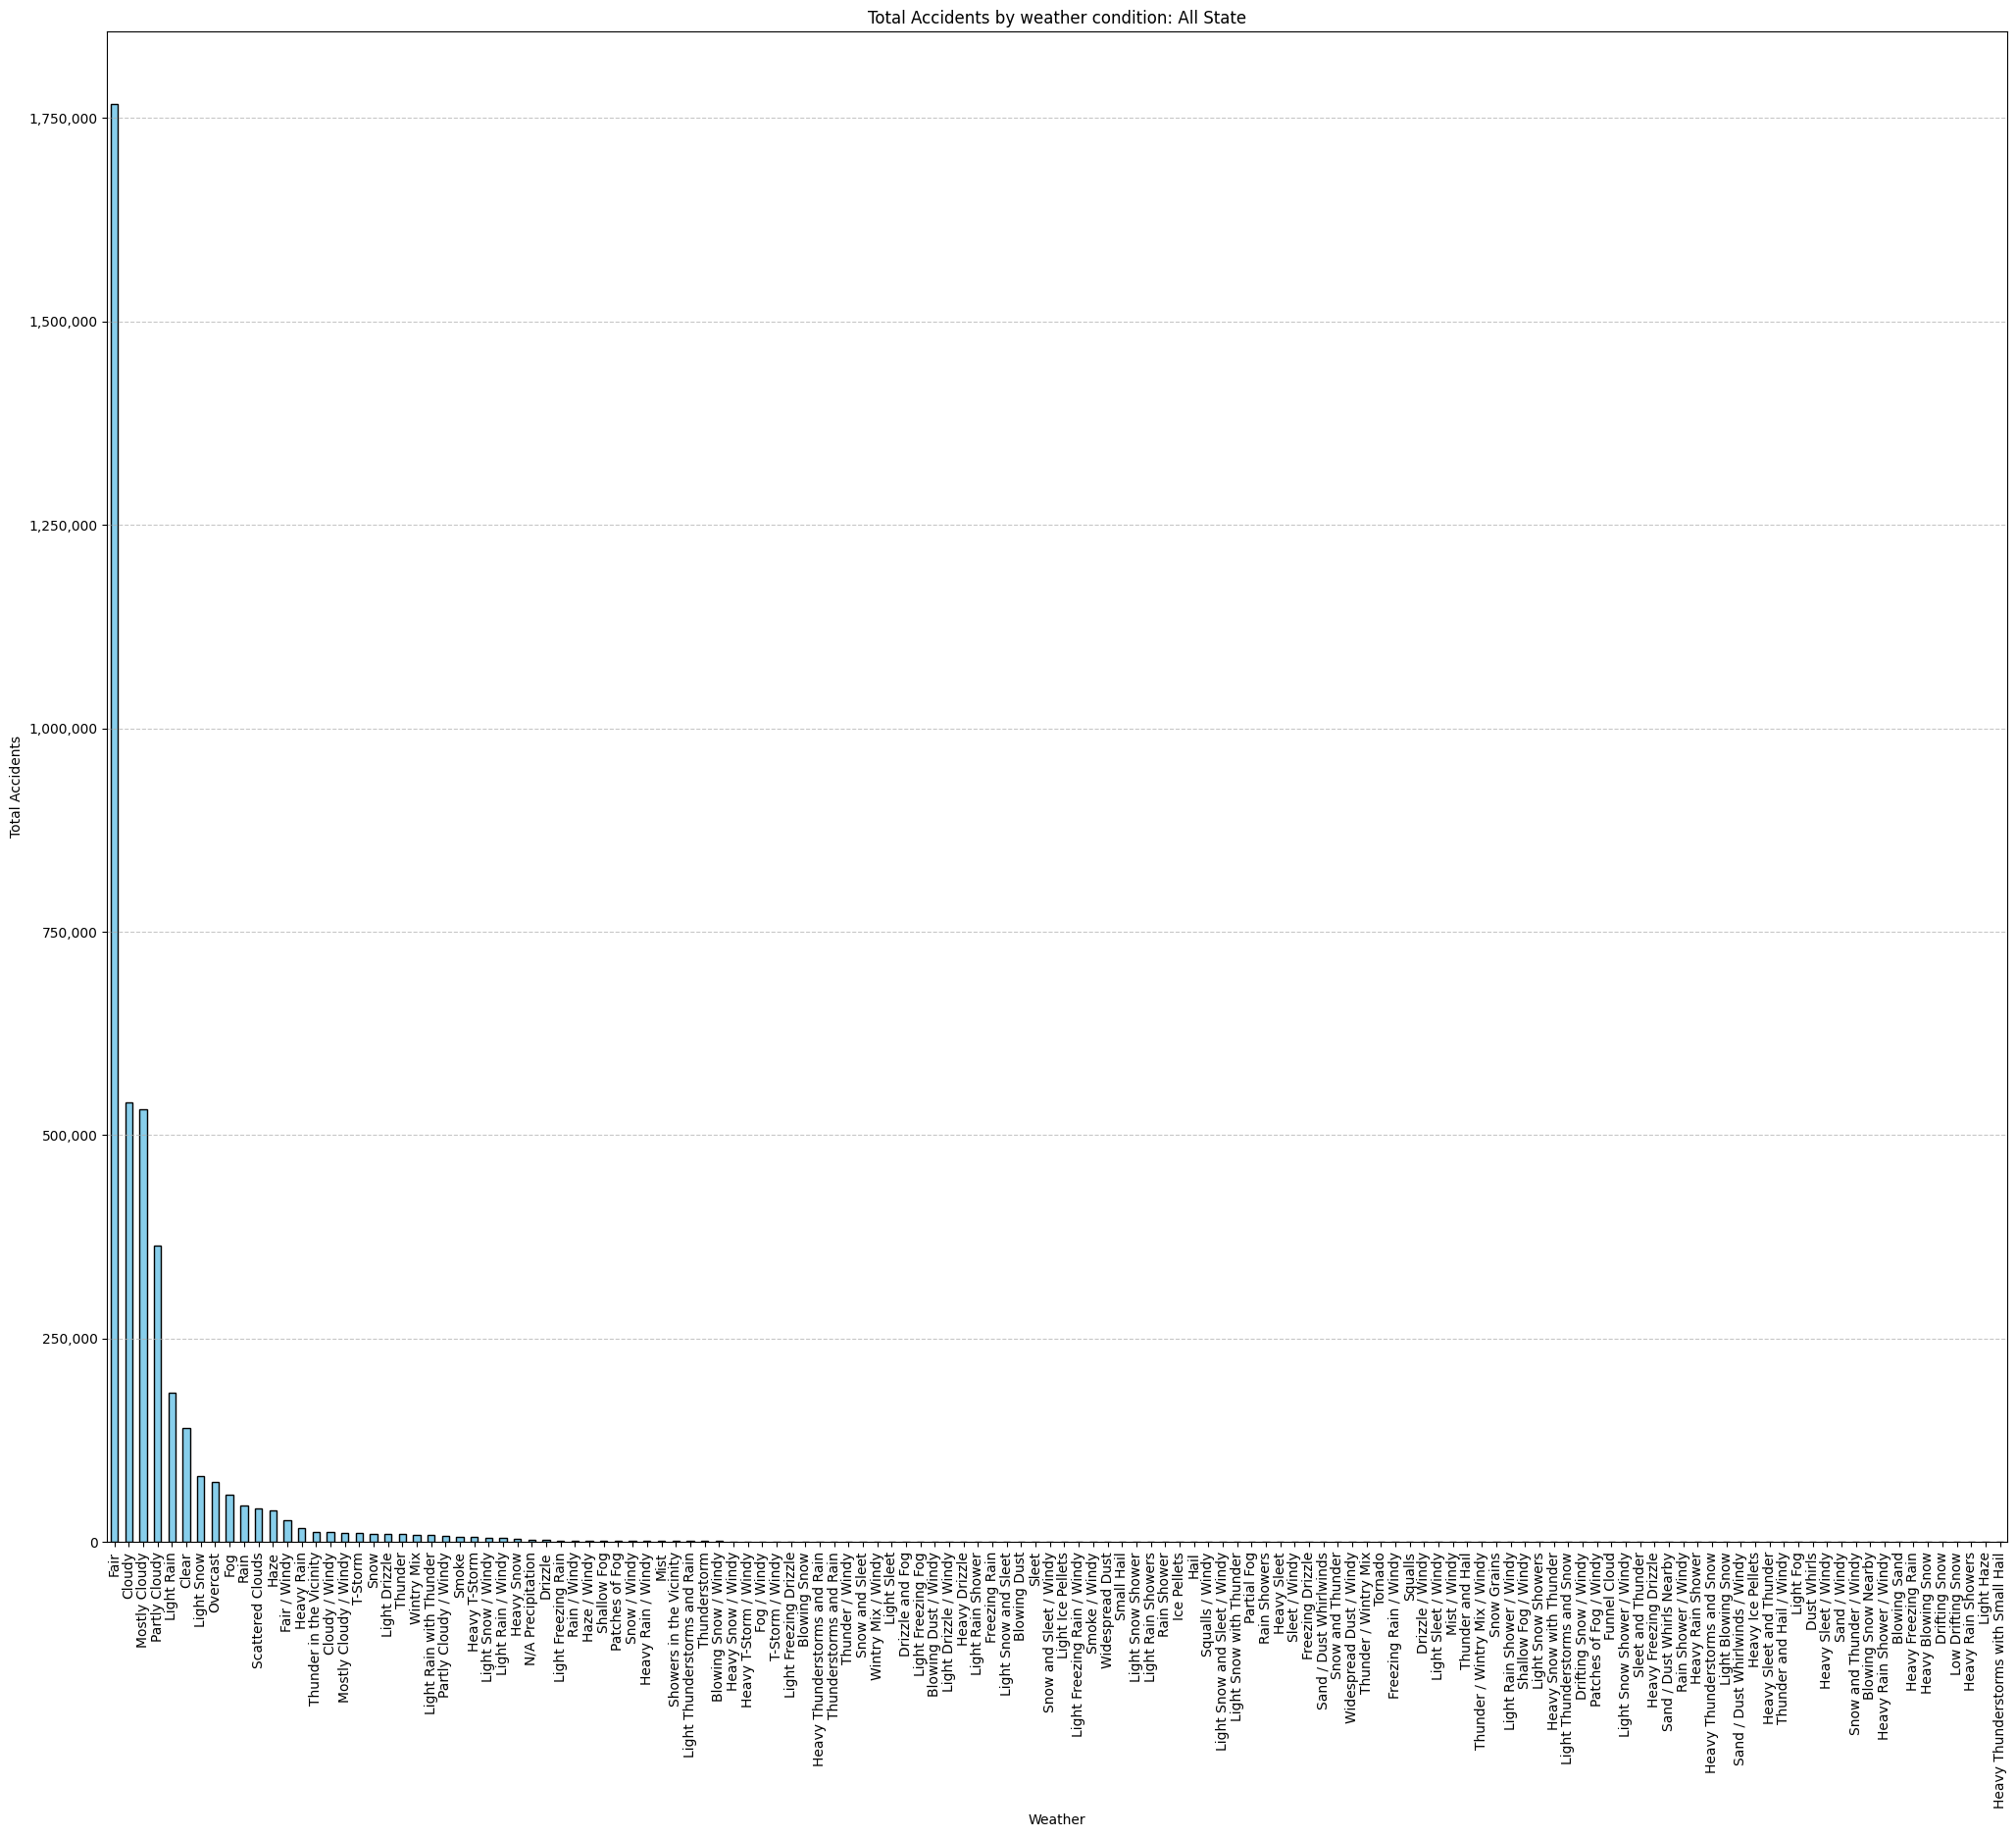

In [15]:
plot_histogram_weather_condition_vs_accident_count(all_data_frame["cleaned_data_file_frame"], "All State")


### TOP 20 City

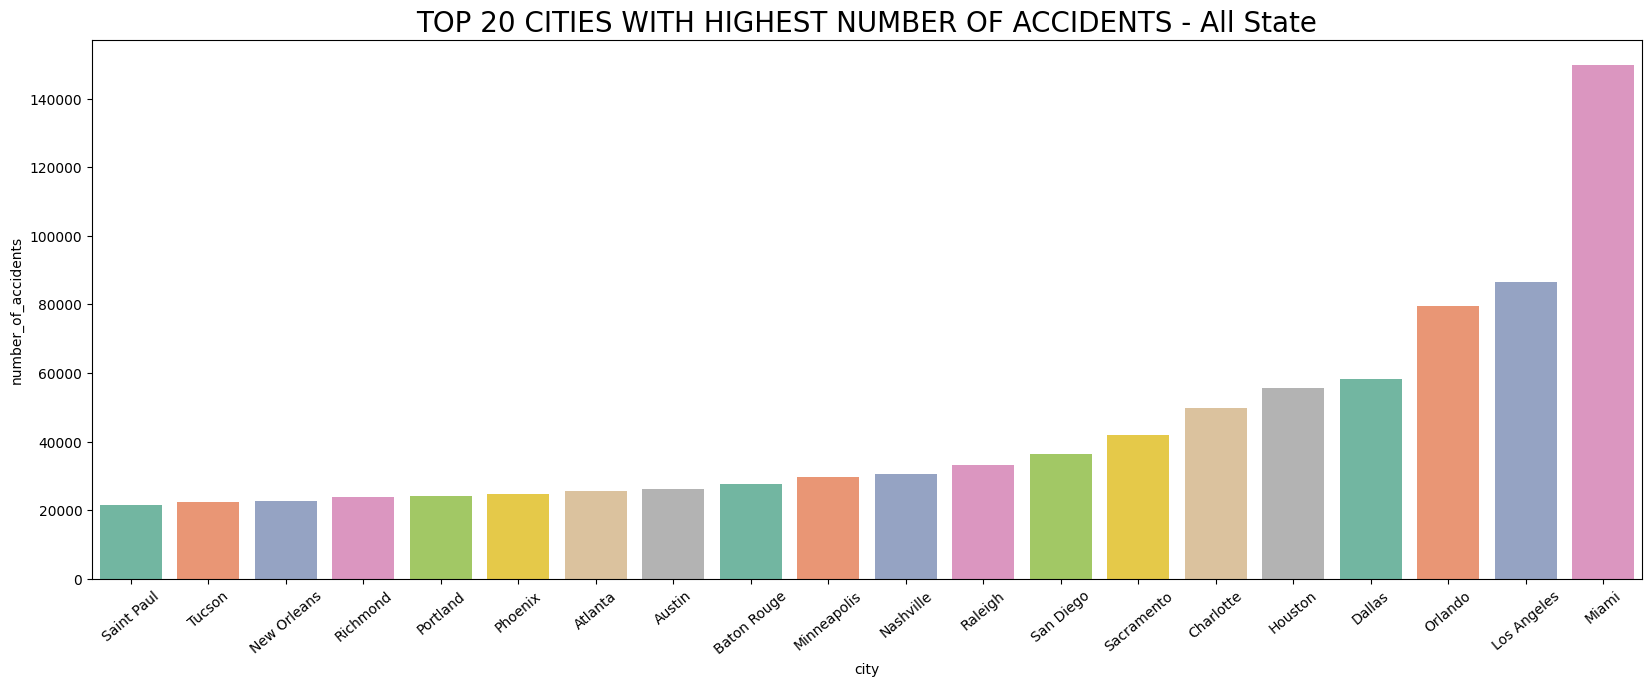

In [20]:
plot_histogram_top_20_city_accident_count(all_data_frame["cleaned_data_file_frame"], "All State")

### Accident Sev level on each state and count

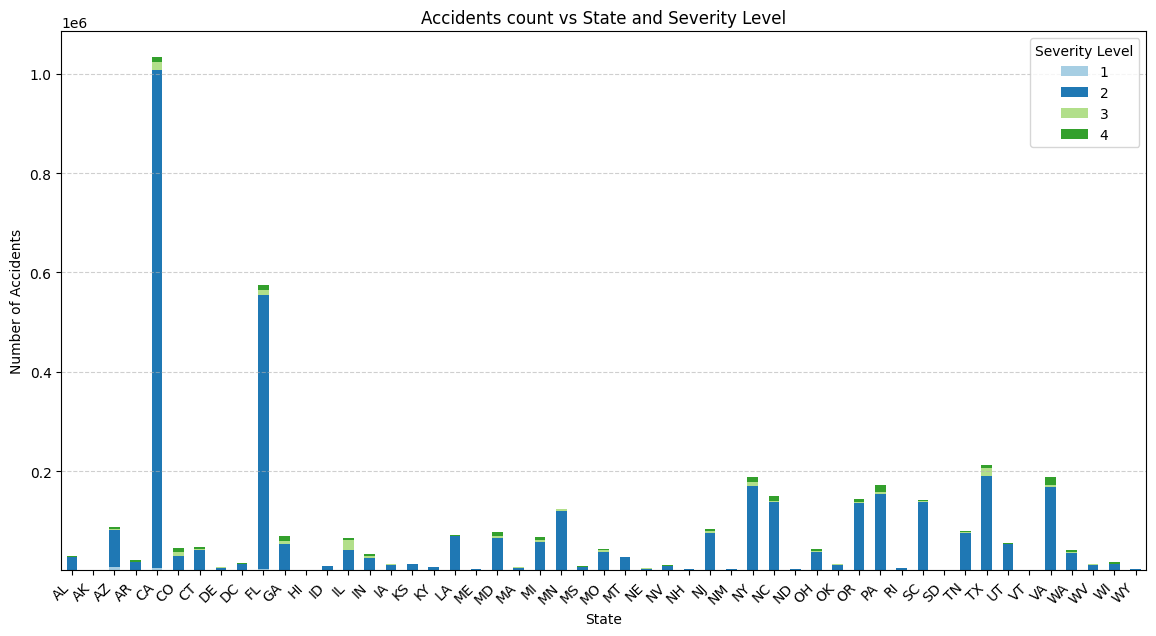

In [23]:
plot_stacked_bar_chart_state_sev_population(all_data_frame["cleaned_data_file_frame"], usa_2023_population_age_18_and_up_data_frame)


### Accident Sev and state

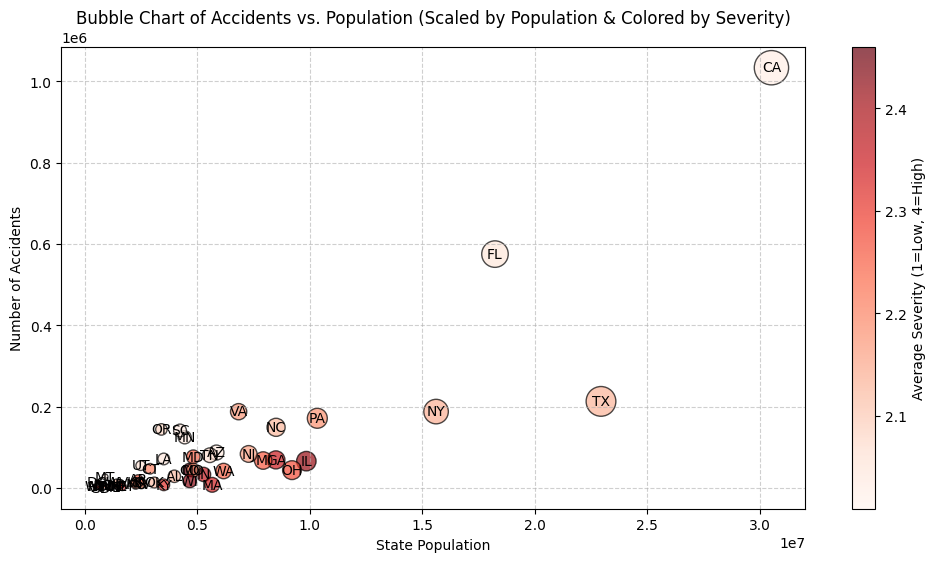

In [18]:
plot_bubble_chart(all_data_frame["cleaned_data_file_frame"], usa_2023_population_age_18_and_up_data_frame)


#### State population %age a Sev level

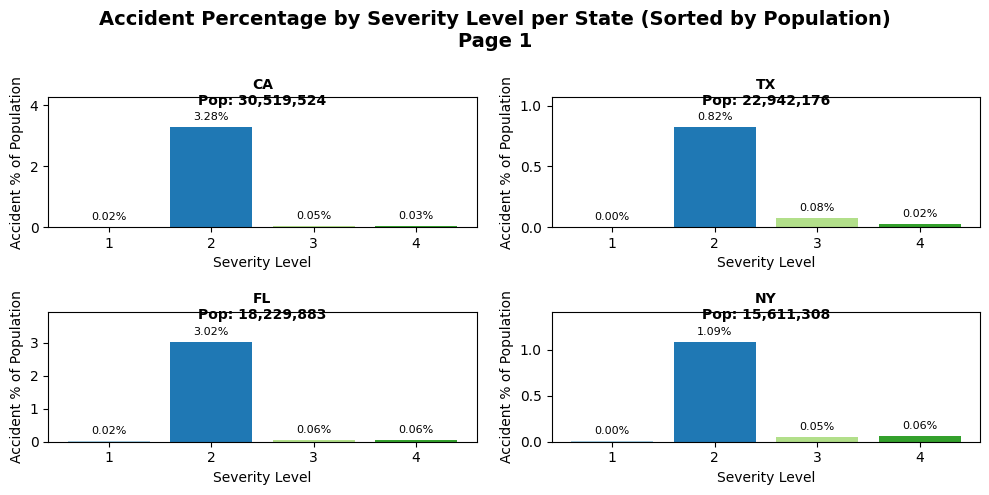

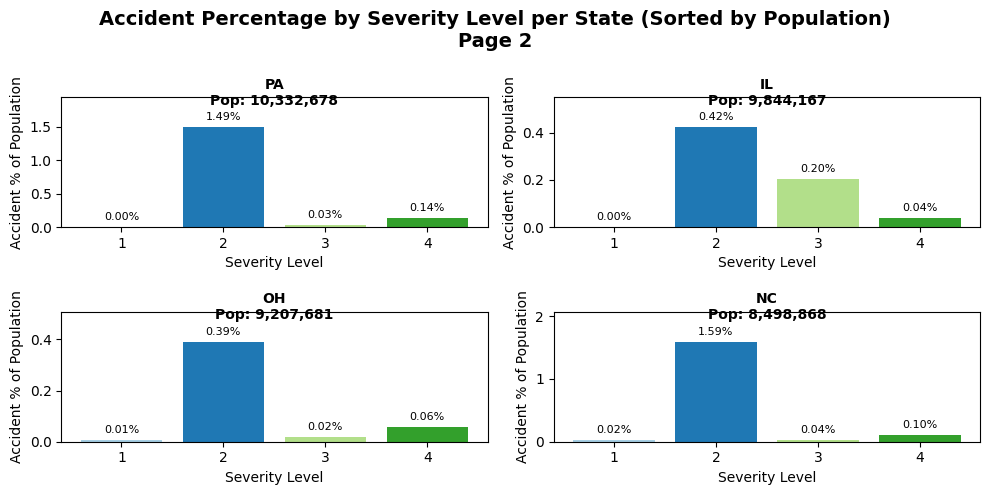

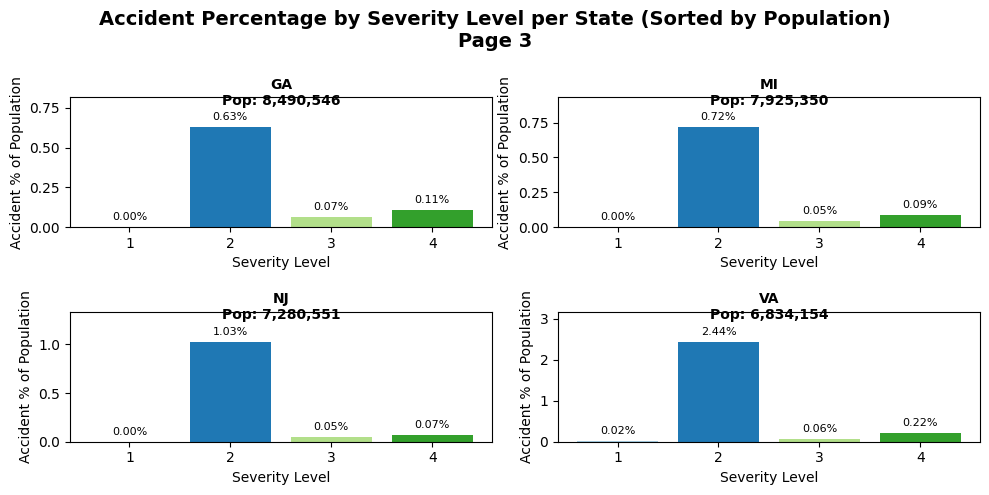

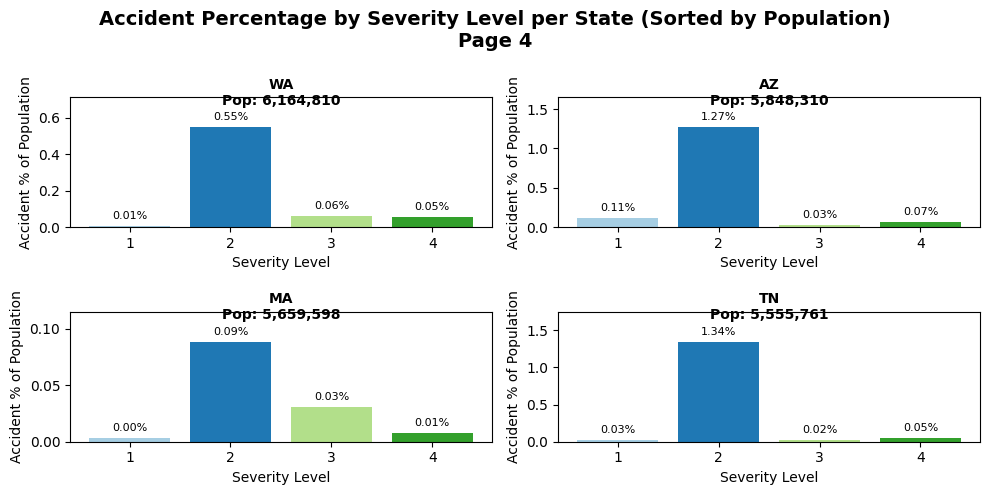

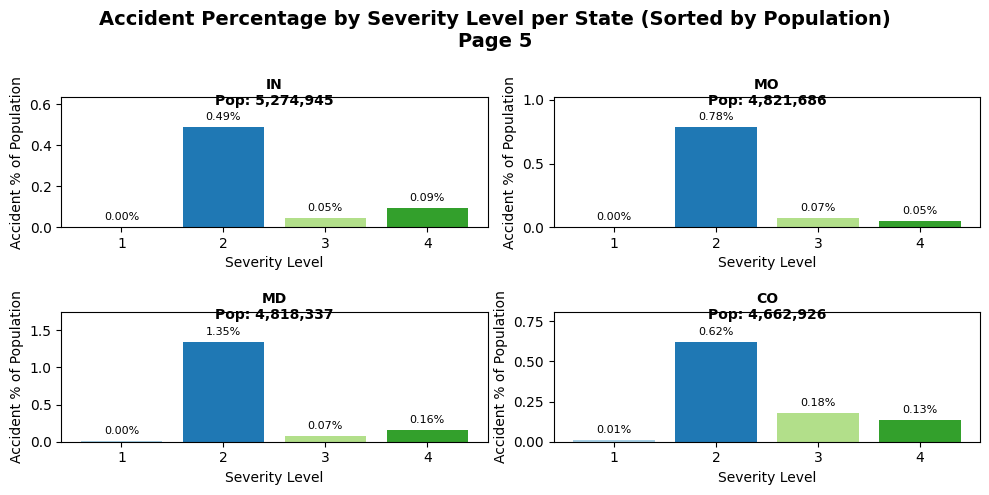

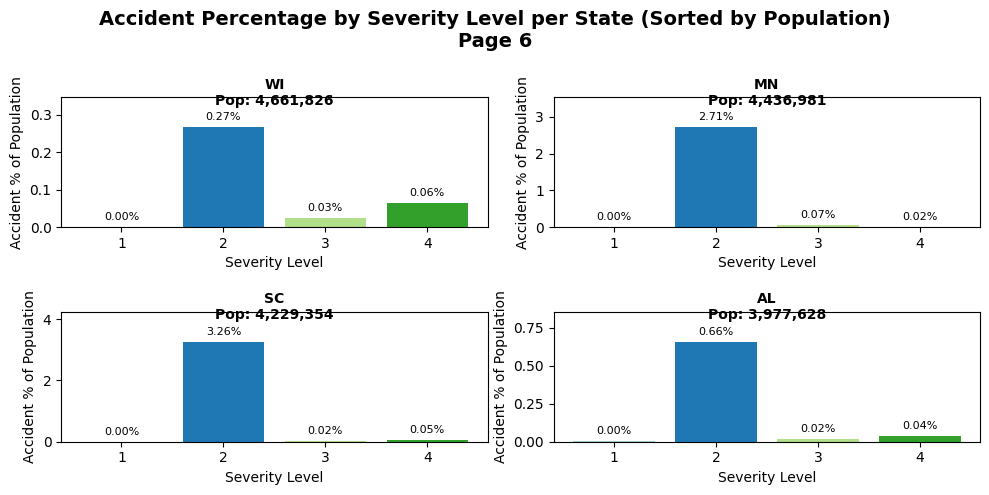

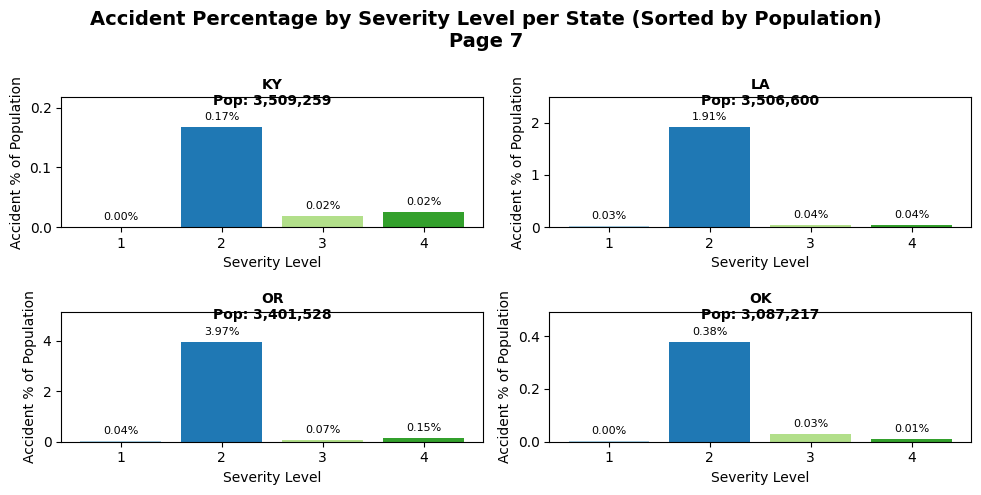

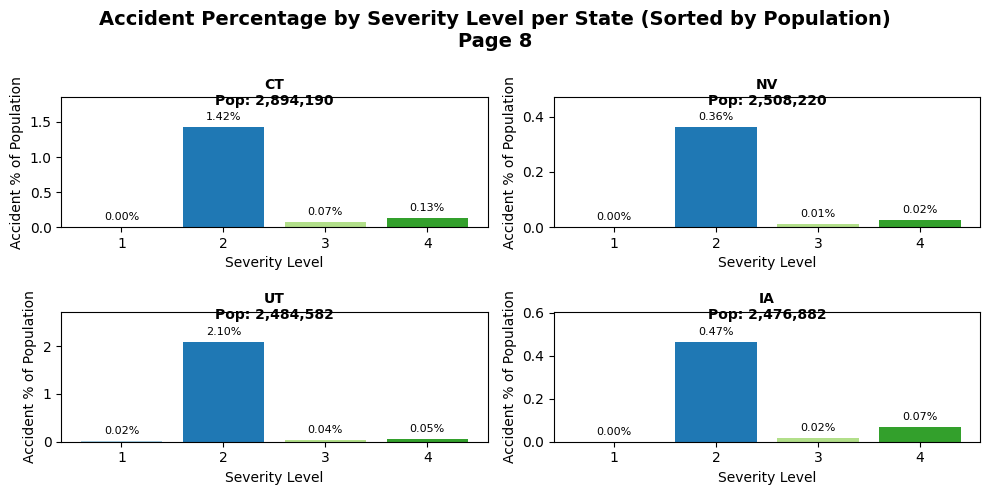

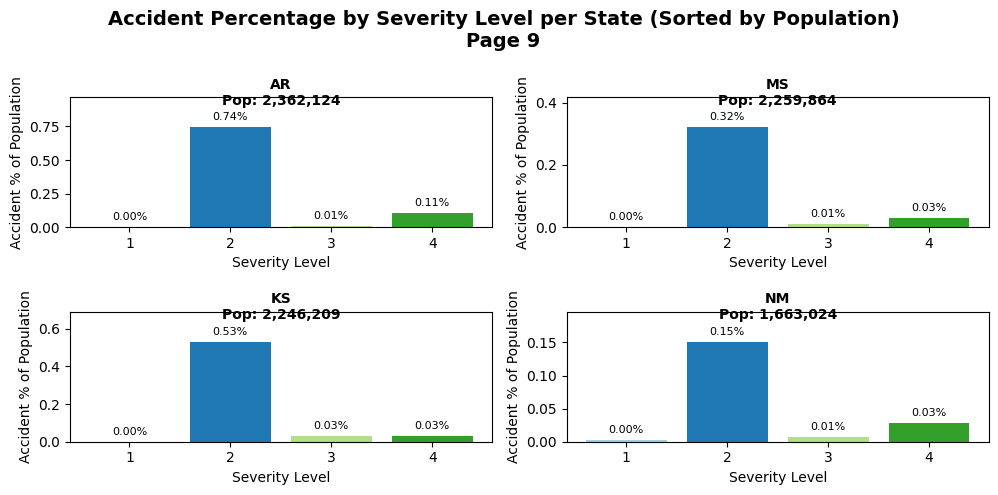

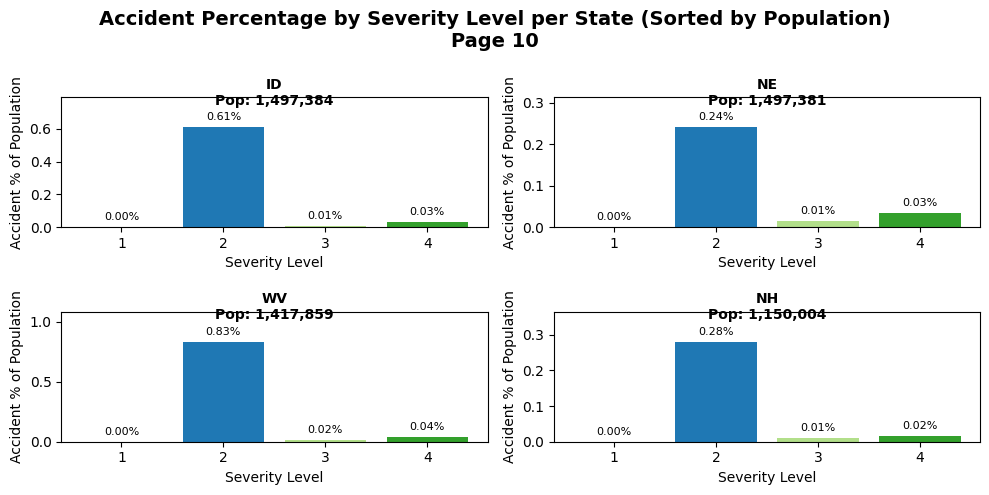

C:\Users\atul1\AppData\Local\Temp\ipykernel_26248\1892078778.py:250: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



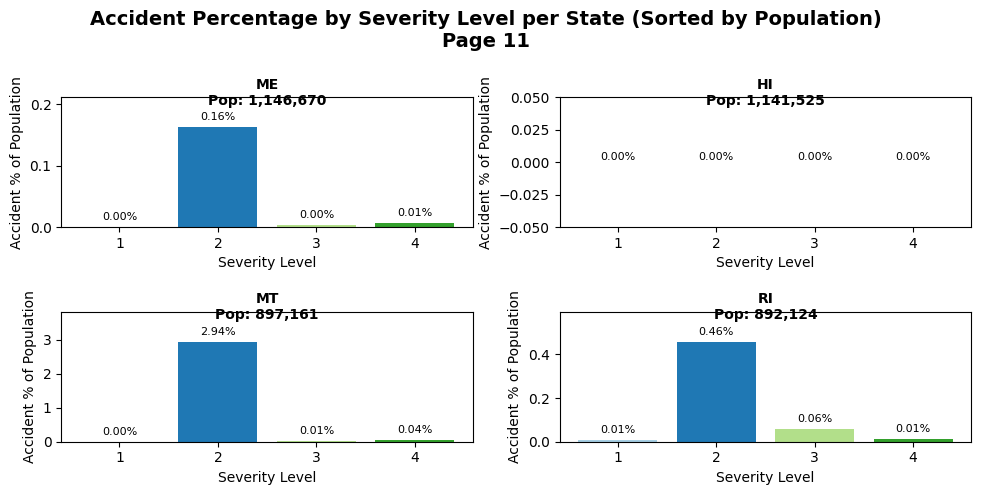

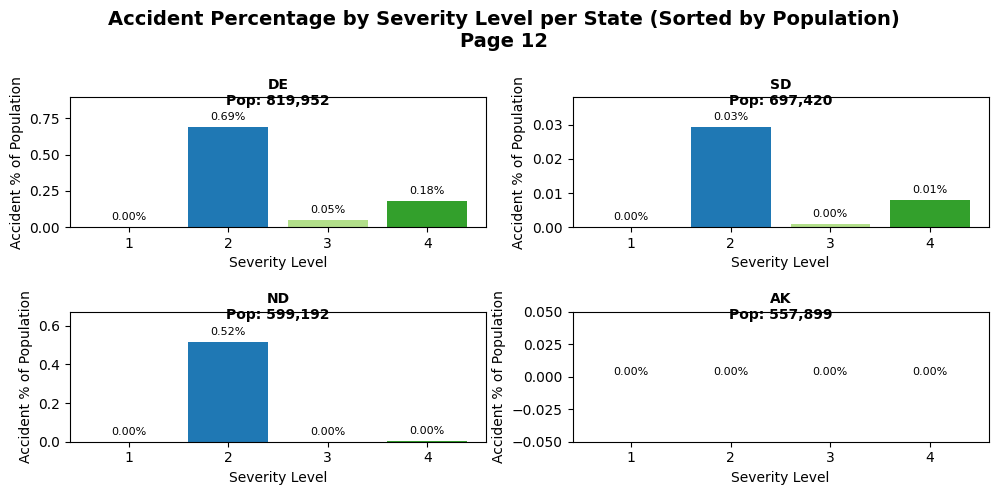

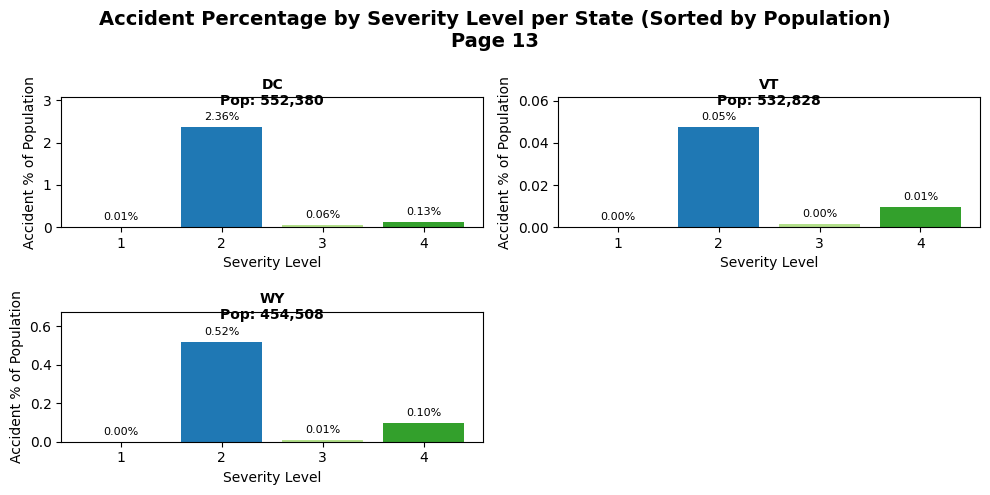

In [19]:
plot_paginated_accident_percentage_improved(all_data_frame["cleaned_data_file_frame"], usa_2023_population_age_18_and_up_data_frame)

### Chi-Square test Hypothesis test

In [31]:
def analyze_visibility_temperature_effect_on_severity(data_frame, num_bins=5, lower_quantile=0.10, upper_quantile=0.90):
    """
    Analyzes the effect of visibility and temperature on accident severity using a Chi-Square test.
    
    Outliers in "Visibility(mi)" and "Temperature(F)" are removed by keeping only rows within the specified quantiles.
    
    Null Hypothesis (H0): Visibility and Temperature have no significant effect on accident severity.
    Alternative Hypothesis (H1): Visibility and Temperature significantly affect accident severity.

    Parameters:
        data_frame (pd.DataFrame): The dataset containing accident details.
        num_bins (int): Number of bins to create for visibility and temperature dynamically.
        lower_quantile (float): Lower quantile cutoff for filtering (default is 0.10).
        upper_quantile (float): Upper quantile cutoff for filtering (default is 0.90).

    Returns:
        dict or None: Chi-square test results including chi-square value, p-value, and degrees of freedom,
                      or None if filtering results in no data.
    """

    # Checking if required columns exist
    required_columns = ["Visibility(mi)", "Temperature(F)", "Severity"]
    missing_columns = [col for col in required_columns if col not in data_frame.columns]
    if missing_columns:
        print(f"Error: Missing columns in dataset: {missing_columns}")
        print(f"Available columns: {data_frame.columns.tolist()}")
        return None

    # Selecting relevant columns
    tmp_df = data_frame[required_columns].copy()

    # Handling missing values: fill with the median values
    tmp_df.loc[:, "Visibility(mi)"] = tmp_df["Visibility(mi)"].fillna(tmp_df["Visibility(mi)"].median())
    tmp_df.loc[:, "Temperature(F)"] = tmp_df["Temperature(F)"].fillna(tmp_df["Temperature(F)"].median())

    # Filtering out outliers: keep only rows within the lower_quantile to upper_quantile for both columns
    vis_lower = tmp_df["Visibility(mi)"].quantile(lower_quantile)
    vis_upper = tmp_df["Visibility(mi)"].quantile(upper_quantile)
    tmp_df = tmp_df[(tmp_df["Visibility(mi)"] >= vis_lower) & (tmp_df["Visibility(mi)"] <= vis_upper)]
    
    temp_lower = tmp_df["Temperature(F)"].quantile(lower_quantile)
    temp_upper = tmp_df["Temperature(F)"].quantile(upper_quantile)
    tmp_df = tmp_df[(tmp_df["Temperature(F)"] >= temp_lower) & (tmp_df["Temperature(F)"] <= temp_upper)]
    
    # Check if any data remains after filtering
    if tmp_df.empty:
        print("No data remains after filtering for the specified quantile range.")
        return None

    # Dynamic Binning for Visibility using percentiles
    _, visibility_bins = pd.qcut(tmp_df["Visibility(mi)"], q=num_bins, retbins=True, labels=False, duplicates="drop")
    visibility_labels = [f"Bin {i+1} ({visibility_bins[i]:.1f} - {visibility_bins[i+1]:.1f} mi)" 
                         for i in range(len(visibility_bins)-1)]
    tmp_df["Visibility_Category"] = pd.qcut(tmp_df["Visibility(mi)"], q=num_bins, labels=visibility_labels, duplicates="drop")

    # Dynamic Binning for Temperature using percentiles
    _, temp_bins = pd.qcut(tmp_df["Temperature(F)"], q=num_bins, retbins=True, labels=False, duplicates="drop")
    temp_labels = [f"Bin {i+1} ({temp_bins[i]:.1f} - {temp_bins[i+1]:.1f}°F)" 
                   for i in range(len(temp_bins)-1)]
    tmp_df["Temperature_Category"] = pd.qcut(tmp_df["Temperature(F)"], q=num_bins, labels=temp_labels, duplicates="drop")

    # Creating a contingency table for Visibility, Temperature, and Severity
    contingency_table = pd.crosstab(index=[tmp_df["Visibility_Category"], tmp_df["Temperature_Category"]],
                                    columns=tmp_df["Severity"])

    # Check if the contingency table is empty
    if contingency_table.empty:
        print("Contingency table is empty after filtering. Consider using a less strict filtering criteria.")
        return None

    # Performing Chi-Square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print()
    # Printing results
    print("\nChi-Square Test Results:")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-Value: {p:.6f}")
    print(f"Degrees of Freedom: {dof}")

    # Interpretation
    alpha = 0.05
    if p < alpha:
        print("\nConclusion: Reject the Null Hypothesis (H0). Visibility and Temperature significantly affect accident severity.")
    else:
        print("\nConclusion: Fail to Reject the Null Hypothesis (H0). No significant effect of visibility and temperature on severity.")

    # Returning results as a dictionary
    return {
        "Chi-Square Statistic": chi2,
        "P-Value": p,
        "Degrees of Freedom": dof,
        "Contingency Table": contingency_table
    }

analyze_visibility_temperature_effect_on_severity(all_data_frame["cleaned_data_file_frame"])



Chi-Square Test Results:
Chi-Square Statistic: 3036.6006
P-Value: 0.000000
Degrees of Freedom: 12

Conclusion: Reject the Null Hypothesis (H0). Visibility and Temperature significantly affect accident severity.


{'Chi-Square Statistic': np.float64(3036.60056123279),
 'P-Value': np.float64(0.0),
 'Degrees of Freedom': 12,
 'Contingency Table': Severity                                        1       2      3      4
 Visibility_Category   Temperature_Category                             
 Bin 1 (5.0 - 10.0 mi) Bin 1 (37.0 - 51.0°F)  2487  575383  19995  28945
                       Bin 2 (51.0 - 61.0°F)  4908  585482  20339  24285
                       Bin 3 (61.0 - 69.0°F)  3978  515936  18148  20985
                       Bin 4 (69.0 - 77.0°F)  4526  592701  24298  26016
                       Bin 5 (77.0 - 85.0°F)  4881  494395  20494  18617}

# EDA for CA, FL and NY

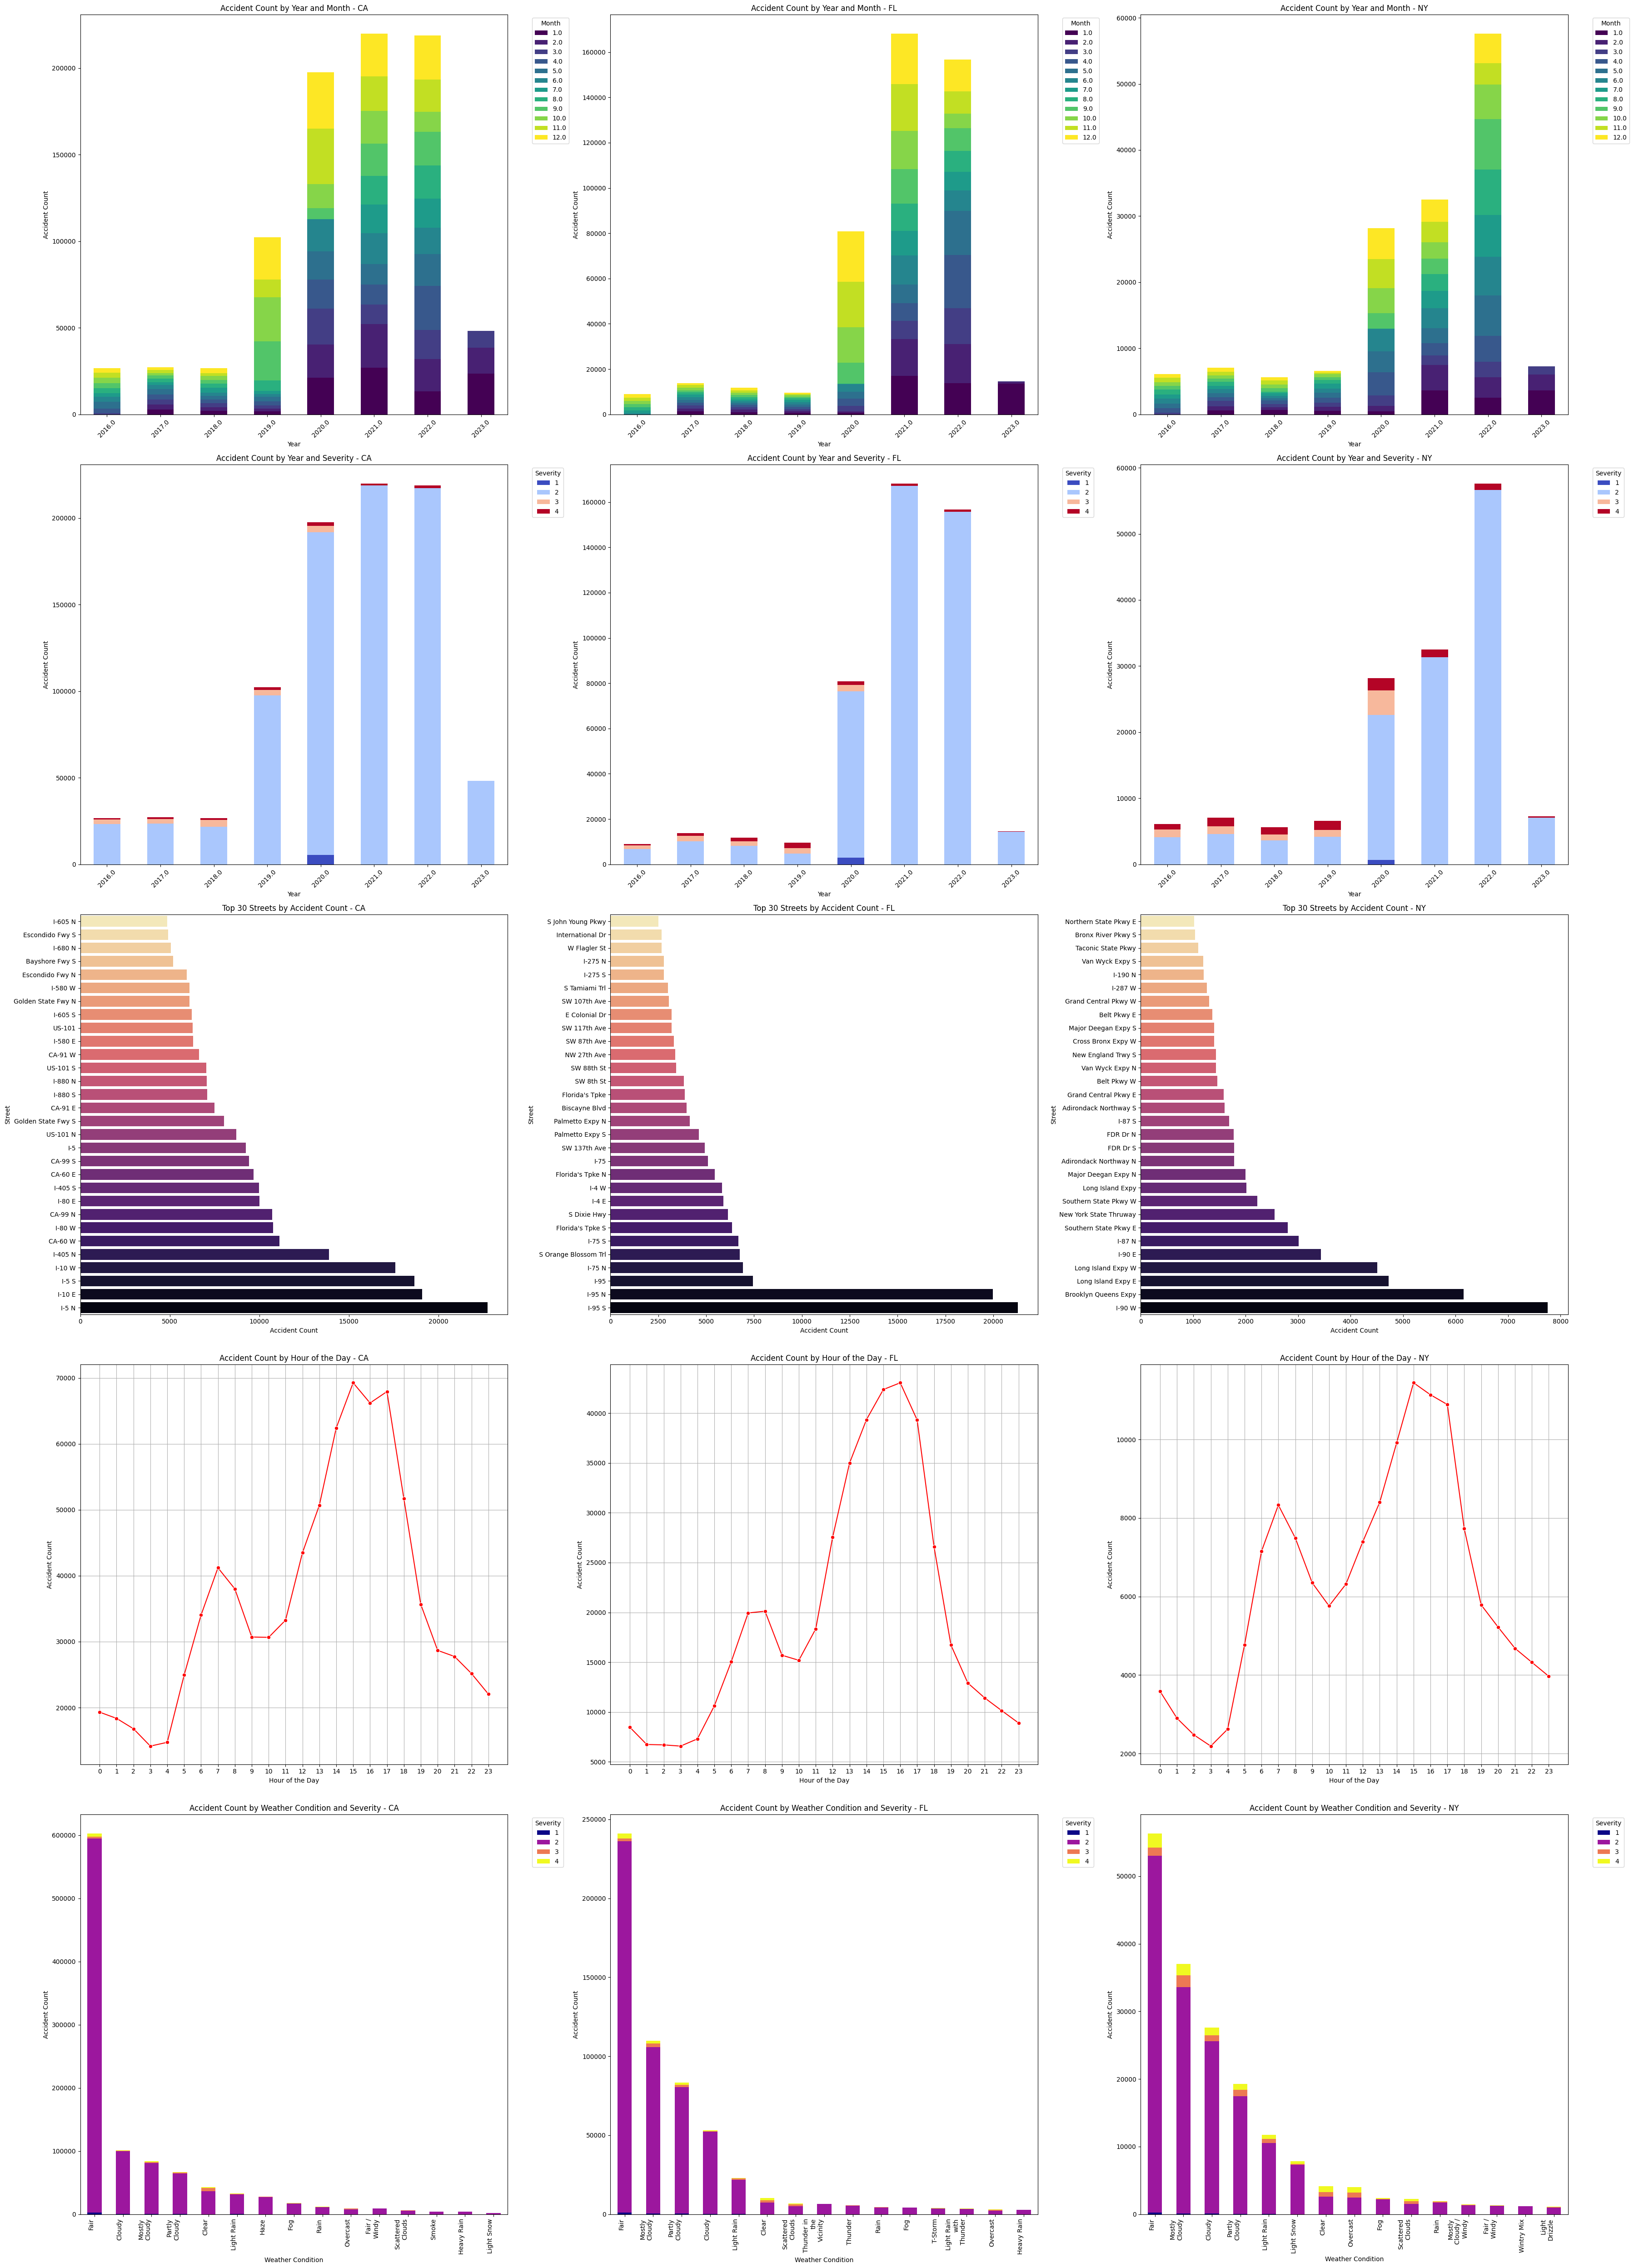

In [10]:
def plot_histogram_weather_condition_vs_accident_count(data_frame, state, ax):
    """Plots a histogram of accident count by weather condition."""
    weather_condition = data_frame["Weather_Condition"].value_counts()
    weather_condition.plot(kind="bar", color="skyblue", edgecolor="black", ax=ax)
    
    ax.set_xlabel("Weather Condition")
    ax.set_ylabel("Total Accidents")
    ax.set_title(f"Total Accidents by Weather Condition - {state}")
    ax.tick_params(axis="x", rotation=90)
    ax.grid(axis="y", linestyle="--", alpha=0.7)


def plot_accident_trend_by_month(data_frame, state, ax):
    """Plots a stacked bar chart for accident count by year and month."""
    
    # Ensure Start_Time is in datetime format
    if "Start_Time" not in data_frame.columns:
        print(f"Error: 'Start_Time' column missing in dataset for {state}")
        return

    if not np.issubdtype(data_frame["Start_Time"].dtype, np.datetime64):
        data_frame["Start_Time"] = pd.to_datetime(data_frame["Start_Time"], errors="coerce")

    # Extract Year and Month
    data_frame["Year"] = data_frame["Start_Time"].dt.year
    data_frame["Month"] = data_frame["Start_Time"].dt.month

    # Group by Year & Month
    accident_counts = data_frame.groupby(["Year", "Month"]).size().unstack()
    accident_counts.plot(kind="bar", stacked=True, colormap="viridis", ax=ax)

    # Formatting
    ax.set_xlabel("Year")
    ax.set_ylabel("Accident Count")
    ax.set_title(f"Accident Count by Year and Month - {state}")
    ax.legend(title="Month", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.tick_params(axis="x", rotation=45)



def plot_accident_trend_by_severity(data_frame, state, ax):
    """Plots a stacked bar chart for accident count by year and severity."""
    data_frame = data_frame.copy()
    data_frame["Year"] = data_frame["Start_Time"].dt.year

    accident_counts = data_frame.groupby(["Year", "Severity"]).size().unstack()
    accident_counts.plot(kind="bar", stacked=True, colormap="coolwarm", ax=ax)

    ax.set_xlabel("Year")
    ax.set_ylabel("Accident Count")
    ax.set_title(f"Accident Count by Year and Severity - {state}")
    ax.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.tick_params(axis="x", rotation=45)


def plot_top_30_streets(data_frame, state, ax):
    """Plots a bar chart of the top 30 streets with the highest accident counts."""
    street_counts = data_frame["Street"].value_counts().nlargest(30)
    sns.barplot(x=street_counts.values, y=street_counts.index, hue=street_counts.index, palette="magma", ax=ax, legend=False)

    ax.set_xlabel("Accident Count")
    ax.set_ylabel("Street")
    ax.set_title(f"Top 30 Streets by Accident Count - {state}")
    ax.invert_yaxis()


def plot_accidents_by_hour(data_frame, state, ax):
    """Plots accident counts by hour of the day."""
    data_frame = data_frame.copy()
    data_frame["Hour"] = data_frame["Start_Time"].dt.hour
    hour_counts = data_frame["Hour"].value_counts().sort_index()

    sns.lineplot(x=hour_counts.index, y=hour_counts.values, marker="o", linestyle="-", color="red", ax=ax)

    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Accident Count")
    ax.set_title(f"Accident Count by Hour of the Day - {state}")
    ax.set_xticks(range(0, 24))
    ax.grid(True)


def plot_weather_vs_severity(data_frame, state, ax):

    # Group and filter top 15 weather conditions
    weather_severity_counts = data_frame.groupby(["Weather_Condition", "Severity"]).size().unstack()
    weather_severity_counts = weather_severity_counts.loc[weather_severity_counts.sum(axis=1).nlargest(15).index]

    # Plot
    weather_severity_counts.plot(kind="bar", stacked=True, colormap="plasma", ax=ax)

    # Adjust labels to avoid overlap
    ax.set_xlabel("Weather Condition")
    ax.set_ylabel("Accident Count")
    ax.set_title(f"Accident Count by Weather Condition and Severity - {state}")
    ax.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Rotate x-tick labels and wrap text
    ax.set_xticklabels(
        [textwrap.fill(label, 10) for label in weather_severity_counts.index],  # Wrap long labels
        rotation=90, ha="right"  # Rotate labels and align right
    )

    # Adjust layout to avoid clipping
    plt.subplots_adjust(bottom=0.3)


# -------------------- Generate Multi-State Subplots --------------------
def generate_subplots_for_states(states_data):
    """
    Generates a multi-state, multi-row plot where each row represents a type of graph,
    and each column represents a state.
    """
    plot_functions = [
        plot_accident_trend_by_month,
        plot_accident_trend_by_severity,
        plot_top_30_streets,
        plot_accidents_by_hour,
        plot_weather_vs_severity
    ]

    fig, axes = plt.subplots(nrows=len(plot_functions), ncols=len(states_data), figsize=(18 * 2, 25 * 2))

    for row_idx, plot_func in enumerate(plot_functions):
        for col_idx, (state, df) in enumerate(states_data.items()):
            ax = axes[row_idx, col_idx]
            plot_func(df, state, ax)

    plt.tight_layout()
    plt.show()

states_data = {
    "CA": all_data_frame["ca_data_frame"],
    "FL": all_data_frame["fl_data_frame"],
    "NY": all_data_frame["ny_data_frame"],
}

# Generate subplots for all states
generate_subplots_for_states(states_data)

Optimization terminated successfully.
         Current function value: 0.294519
         Iterations 6

Logistic Regression: Bad Weather vs. Severity
                           Logit Regression Results                           
Dep. Variable:        Severe_Accident   No. Observations:              3354197
Model:                          Logit   Df Residuals:                  3354195
Method:                           MLE   Df Model:                            1
Date:                Sat, 22 Feb 2025   Pseudo R-squ.:               7.712e-05
Time:                        20:52:06   Log-Likelihood:            -9.8788e+05
converged:                       True   LL-Null:                   -9.8795e+05
Covariance Type:            nonrobust   LLR p-value:                 5.231e-35
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.3522      0.002  -1196.604      0.000    

<Figure size 1000x600 with 0 Axes>

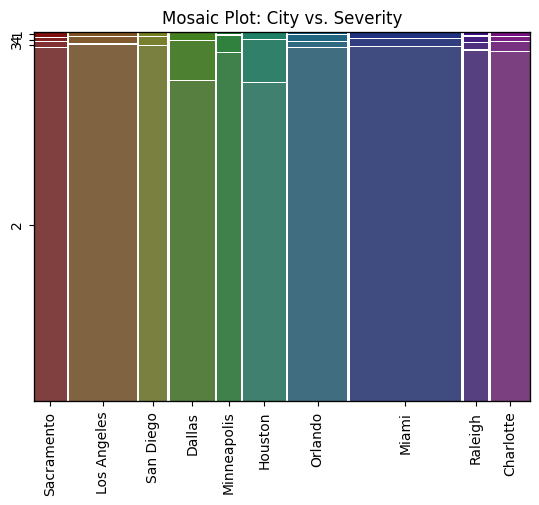

/var/folders/1m/c6l0rfk529z4tsy9l5jrvr4w0000gn/T/ipykernel_19209/4232431669.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_signal = severe_accidents[df['Traffic_Signal'] == 0].shape[0]
/var/folders/1m/c6l0rfk529z4tsy9l5jrvr4w0000gn/T/ipykernel_19209/4232431669.py:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  with_signal = severe_accidents[df['Traffic_Signal'] == 1].shape[0]



Z-Test for Traffic Signals vs. Severity
Z-statistic: -265.0766
Significant Impact

Chi-Square Test: Junction vs. Severity
Chi-square Statistic: 18749.2724, P-value: 0.0000
Significant Impact

Chi-Square Test: Crossing vs. Severity
Chi-square Statistic: 24607.4359, P-value: 0.0000
Significant Impact

Chi-Square Test: Stop vs. Severity
Chi-square Statistic: 1145.2946, P-value: 0.0000
Significant Impact

T-Test: Visibility vs. Severity
T-statistic: -43.9902, P-value: 0.0000
Significant Impact

Pearson Correlation: Wind Speed vs. Severity
Correlation Coefficient: 0.0280, P-value: 0.0000
Significant Impact


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, pearsonr
from statsmodels.discrete.count_model import Poisson
from statsmodels.graphics.mosaicplot import mosaic

def load_data(file_id):
    output_dir = "../data/all_data/"
    output_path = f"{output_dir}cleaned_data_{file_id}.csv"

    # Download data if it does not exist
    if not os.path.exists(output_path):
        gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

    df = pd.read_csv(output_path, sep=",", low_memory=False)

    # Convert Start_Time and End_Time to datetime
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

    # Drop rows where conversion failed
    df = df[df['Start_Time'].notna() & df['End_Time'].notna()]

    return df

def perform_inferential_tests(df):
    """
    Performs multiple inferential statistical tests on accident severity data for the entire dataset.

    Tests included:
    - Logistic Regression: Extreme Weather vs. Severity
    - ANOVA: Time of Day vs. Severity
    - Chi-Square + Mosaic Plot: City vs. Severity
    - Z-Test: Traffic Signals vs. Severity
    - Chi-Square: Road Features vs. Severity
    - T-Test: Visibility vs. Severity
    - Pearson Correlation: Wind Speed vs. Severity

    Parameters:
    - df (pd.DataFrame): The accident dataset for all states.
    """

    # Logistic Regression: Does Extreme Weather Increase Severity?
    if 'Weather_Condition' in df.columns:
        df['Severe_Accident'] = (df['Severity'] >= 3).astype(int)  # Binary outcome
        df['Bad_Weather'] = df['Weather_Condition'].isin(['Rain', 'Snow', 'Fog']).astype(int)

        logit_model = sm.Logit(df['Severe_Accident'], sm.add_constant(df['Bad_Weather'])).fit()
        print("\nLogistic Regression: Bad Weather vs. Severity")
        print(logit_model.summary())

    # ANOVA Test: Time of Day vs. Severity
    if 'Start_Time' in df.columns:
        df['Hour'] = pd.to_datetime(df['Start_Time']).dt.hour
        df['Time_of_Day'] = pd.cut(df['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

        anova_model = ols('Severity ~ C(Time_of_Day)', data=df).fit()
        anova_table = sm.stats.anova_lm(anova_model, typ=2)

        print("\nANOVA Test: Time of Day vs. Severity")
        print(anova_table)

    # Chi-Square Test + Mosaic Plot: Are Certain Cities More Prone to Severe Accidents?
    if 'City' in df.columns and 'Severity' in df.columns:
        top_cities = df['City'].value_counts().head(10).index
        df_filtered = df[df['City'].isin(top_cities)]

        contingency_table = pd.crosstab(df_filtered['City'], df_filtered['Severity'])
        chi2, p, _, _ = chi2_contingency(contingency_table)

        print("\nChi-Square Test: City vs. Severity")
        print(f"Chi-square Statistic: {chi2:.4f}, P-value: {p:.4f}")
        print("Significant Impact" if p < 0.05 else "No Significant Impact")

        # Mosaic Plot for the top 10 cities
        plt.figure(figsize=(10, 6))  
        mosaic(df_filtered, ['City', 'Severity'], title="Mosaic Plot: City vs. Severity", 
               label_rotation=90, labelizer=lambda k: k[1] if k[0] == 'Severity' else '')  
        plt.show()

    # Z-Test for Proportions: Do Traffic Signals Reduce Severe Accidents?
    if 'Traffic_Signal' in df.columns:
        severe_accidents = df[df['Severity'] >= 3]
        no_signal = severe_accidents[df['Traffic_Signal'] == 0].shape[0]
        with_signal = severe_accidents[df['Traffic_Signal'] == 1].shape[0]

        p1 = with_signal / severe_accidents.shape[0]
        p2 = no_signal / severe_accidents.shape[0]
        p_combined = (with_signal + no_signal) / (severe_accidents.shape[0] * 2)
        z_stat = (p1 - p2) / np.sqrt(p_combined * (1 - p_combined) * (1 / with_signal + 1 / no_signal))

        print("\nZ-Test for Traffic Signals vs. Severity")
        print(f"Z-statistic: {z_stat:.4f}")
        print("Significant Impact" if abs(z_stat) > 1.96 else "No Significant Impact")

    # Chi-Square Test: Road Features vs. Severity
    road_features = ["Junction", "Crossing", "Stop"]
    for feature in road_features:
        if feature in df.columns:
            contingency_table = pd.crosstab(df[feature], df['Severity'])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            print(f"\nChi-Square Test: {feature} vs. Severity")
            print(f"Chi-square Statistic: {chi2:.4f}, P-value: {p:.4f}")
            print("Significant Impact" if p < 0.05 else "No Significant Impact")

    # T-Test: Does Visibility Affect Severity?
    if 'Visibility(mi)' in df.columns:
        low_visibility = df[df['Visibility(mi)'] <= df['Visibility(mi)'].median()]['Severity']
        high_visibility = df[df['Visibility(mi)'] > df['Visibility(mi)'].median()]['Severity']

        t_stat, p_value = ttest_ind(low_visibility, high_visibility)
        print("\nT-Test: Visibility vs. Severity")
        print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
        print("Significant Impact" if p_value < 0.05 else "No Significant Impact")

    # Pearson Correlation: Does Wind Speed Influence Severity?
    if 'Wind_Speed(mph)' in df.columns:
        corr, p_value = pearsonr(df['Wind_Speed(mph)'], df['Severity'])
        print("\nPearson Correlation: Wind Speed vs. Severity")
        print(f"Correlation Coefficient: {corr:.4f}, P-value: {p_value:.4f}")
        print("Significant Impact" if p_value < 0.05 else "No Significant Impact")

# Load the dataset for the entire US
data = load_data("19YfLnrlvO9TVgLfOWZkXiP3RU4SzeEd4")  
perform_inferential_tests(data)


Estimated severity for New York :

 Estimated Probability of Each Severity Level (Sample-Based):
  - P(Severity 2) = 1.0000 (100.00%)

 Projected Number of Accidents in Full Population:
  - Estimated Count of Severity 2: 308,459

 Estimated Population Mean (Severity Level):
  - Sample Mean: 2.29
  - Estimated Population Mean: 2.29
  - 95% Confidence Interval: (2.28, 2.31)


Estimated severity for California :

 Estimated Probability of Each Severity Level (Sample-Based):
  - P(Severity 3) = 1.0000 (100.00%)

 Projected Number of Accidents in Full Population:
  - Estimated Count of Severity 3: 1,536,288

 Estimated Population Mean (Severity Level):
  - Sample Mean: 2.18
  - Estimated Population Mean: 2.18
  - 95% Confidence Interval: (2.17, 2.19)


Estimated severity for Florida :

 Estimated Probability of Each Severity Level (Sample-Based):
  - P(Severity 2) = 1.0000 (100.00%)

 Projected Number of Accidents in Full Population:
  - Estimated Count of Severity 2: 759,778

 Estimated Po

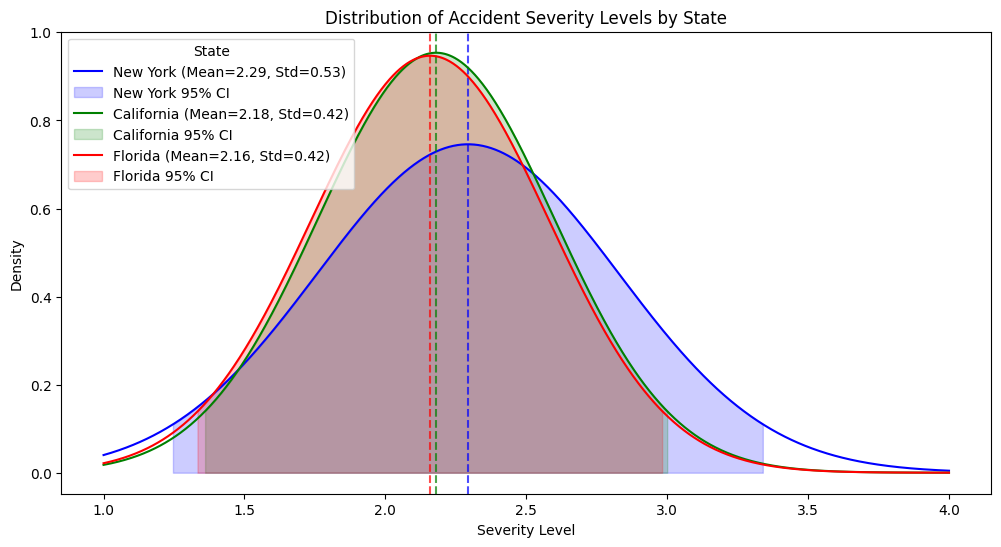

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from collections import Counter
import os

def estimate_severity_probability(data):
    """
    Estimates the probability of each accident severity level using a random sample
    and predicts the expected counts for the entire population.

    Parameters:
    - data (pd.DataFrame): The full dataset.

    Returns:
    - severity_probabilities (dict): Estimated probability of each severity level.
    - sample_std (float): Standard deviation of severity levels in the sample.
    """
    # Get total population size (total rows in full dataset)
    total_population_size = len(data)

    # Select a random subset of 5,000 rows
    data_sample = data.sample(random_state=42)

    # Compute severity distribution in the sample
    severity_counts = Counter(data_sample['Severity'])
    total_sample_size = len(data_sample)
    
    # Compute probabilities for each severity level
    severity_probabilities = {severity: count / total_sample_size for severity, count in severity_counts.items()}

    # Predict severity counts for full population
    estimated_population_counts = {severity: int(prob * total_population_size) for severity, prob in severity_probabilities.items()}

    # Print results
    print("\n Estimated Probability of Each Severity Level (Sample-Based):")
    for severity, prob in severity_probabilities.items():
        print(f"  - P(Severity {severity}) = {prob:.4f} ({prob*100:.2f}%)")

    print("\n Projected Number of Accidents in Full Population:")
    for severity, count in estimated_population_counts.items():
        print(f"  - Estimated Count of Severity {severity}: {count:,}")

    return severity_probabilities, data_sample['Severity'].std()

def predict_population_mean(data):
    """
    Predicts the population mean severity level using a sample
    and calculates a confidence interval.

    Parameters:
    - data (pd.DataFrame): The full dataset.

    Returns:
    - sample_mean (float): Estimated mean severity level.
    - lower_bound (float): Lower bound of the 95% confidence interval.
    - upper_bound (float): Upper bound of the 95% confidence interval.
    """
    # Get total population size
    total_population_size = len(data)

    # Select a random subset of 5,000 rows
    data_sample = data.sample(n=5000, random_state=42)

    # Compute sample mean and standard deviation
    sample_mean = data_sample['Severity'].mean()
    sample_std = data_sample['Severity'].std()
    sample_size = len(data_sample)

    # Compute standard error
    standard_error = sample_std / np.sqrt(sample_size)

    # Compute 95% confidence interval
    z_score = norm.ppf(0.975)  # Z-score for 95% CI
    margin_of_error = z_score * standard_error
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error

    # Print results
    print("\n Estimated Population Mean (Severity Level):")
    print(f"  - Sample Mean: {sample_mean:.2f}")
    print(f"  - Estimated Population Mean: {sample_mean:.2f}")
    print(f"  - 95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

    return sample_mean, lower_bound, upper_bound, sample_std

def plot_bell_curves_with_insights(state_data):
    """
    Plots enhanced bell curves for accident severity across different states
    with mean indicators, confidence intervals, and actual severity distributions.

    Parameters:
    - state_data (dict): Dictionary containing mean and standard deviation for each state.
    """
    x = np.linspace(1, 4, 1000)  # X-axis range for severity levels
    plt.figure(figsize=(12, 6))

    # Define colors for each state
    state_colors = {
        "New York": "blue",
        "California": "green",
        "Florida": "red"
    }

    for state, stats in state_data.items():
        mean = stats["mean"]
        std = stats["std"]
        y = norm.pdf(x, mean, std)  # Compute normal distribution
        
        # Plot bell curve
        plt.plot(x, y, label=f"{state} (Mean={mean:.2f}, Std={std:.2f})", color=state_colors[state])
        
        # Add vertical line for the mean
        plt.axvline(mean, color=state_colors[state], linestyle="dashed", alpha=0.7)
        
        # Shade the 95% confidence interval
        lower_bound = mean - 1.96 * std
        upper_bound = mean + 1.96 * std
        plt.fill_between(x, norm.pdf(x, mean, std), where=(x >= lower_bound) & (x <= upper_bound), 
                         color=state_colors[state], alpha=0.2, label=f"{state} 95% CI")

    # Labels and title
    plt.xlabel("Severity Level")
    plt.ylabel("Density")
    plt.title("Distribution of Accident Severity Levels by State")
    plt.legend(title="State", loc="upper left")

    # Show plot
    plt.show()


# State data storage
state_list_ids = {
    "New York": "1mtOvSHslo4_Hll-PCqBblPticARKV4jd",
    "California": "1CHspEwcsJZ5ZC3zZq9BPf4lTMNQJQOPQ",
    "Florida": "1hqsDRaN3pbCAdv1w7atr5nJiBE0Qgihw",
}

# Dictionary to store state data for visualization
state_data = {}

# Loop through each state and process data
for state, file_id in state_list_ids.items():
    data = load_data(file_id)  # Load data for the state
    print(f"Estimated severity for {state} :")
    severity_probs, sample_std = estimate_severity_probability(data)
    sample_mean, lower_bound, upper_bound, sample_std = predict_population_mean(data)
    print("\n")

    # Store results for visualization
    state_data[state] = {"mean": sample_mean, "std": sample_std}

# Plot bell curves for severity distributions across states
plot_bell_curves_with_insights(state_data)



Prediction for New York:


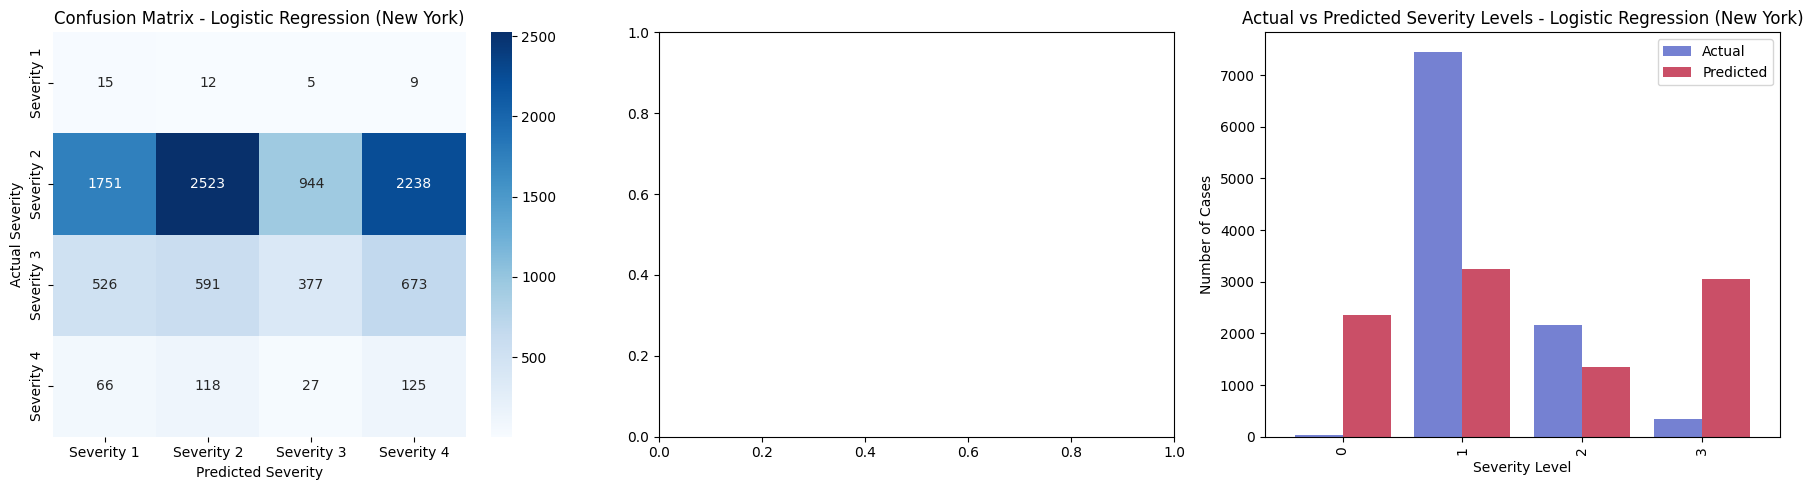

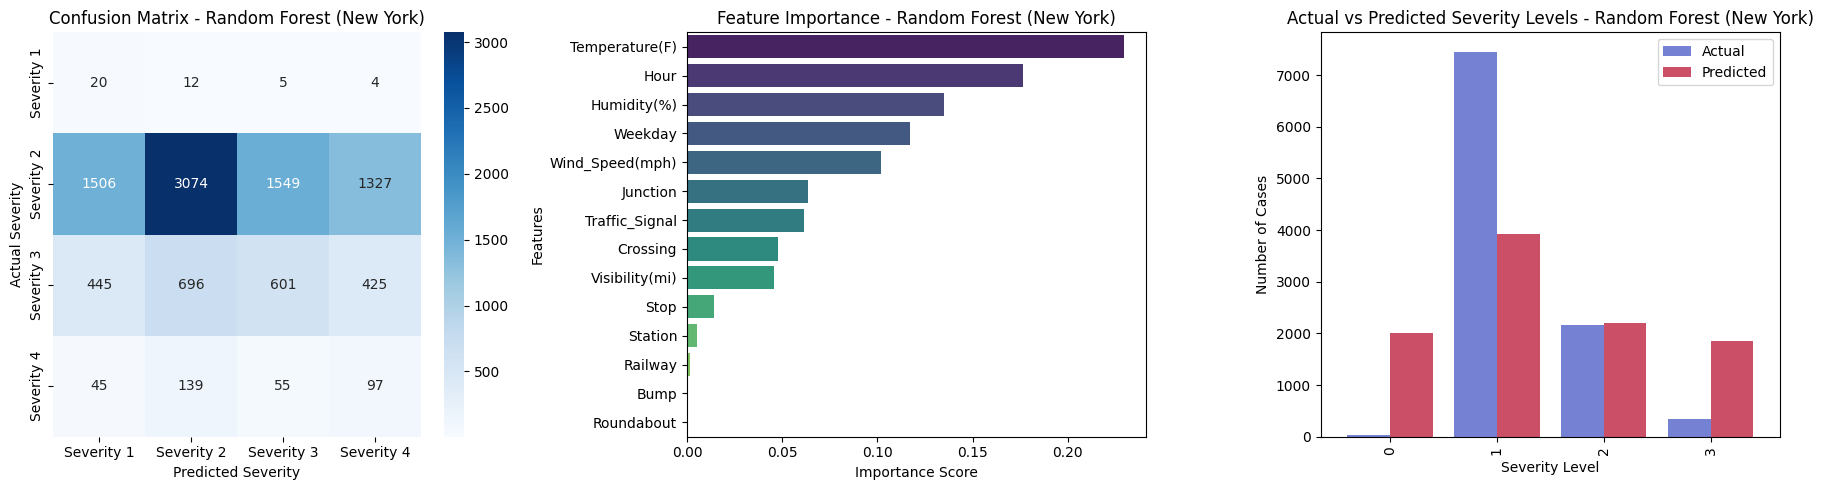

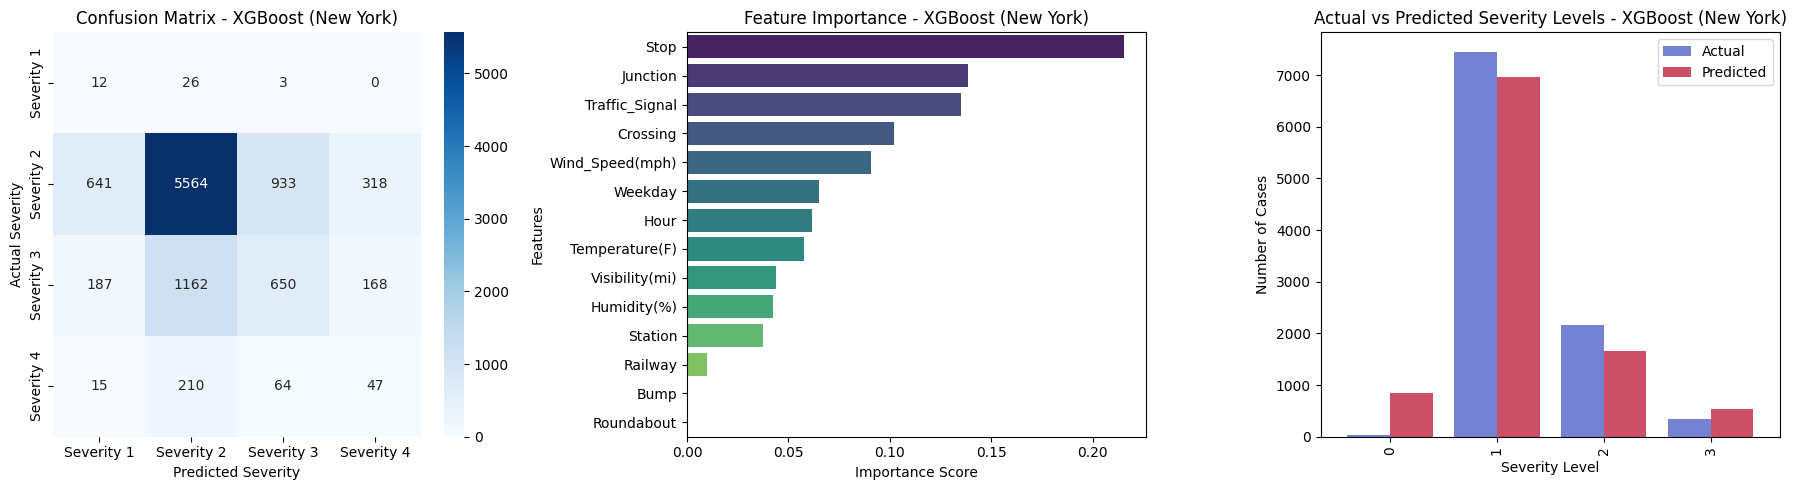


Model Comparison Results:
              Model  Accuracy  Macro Precision  Macro Recall  Weighted F1-score
Logistic Regression    0.3040         0.275949      0.312559           0.400570
      Random Forest    0.3792         0.279549      0.366531           0.465481
            XGBoost    0.6273         0.323838      0.369691           0.653012



Prediction for California:


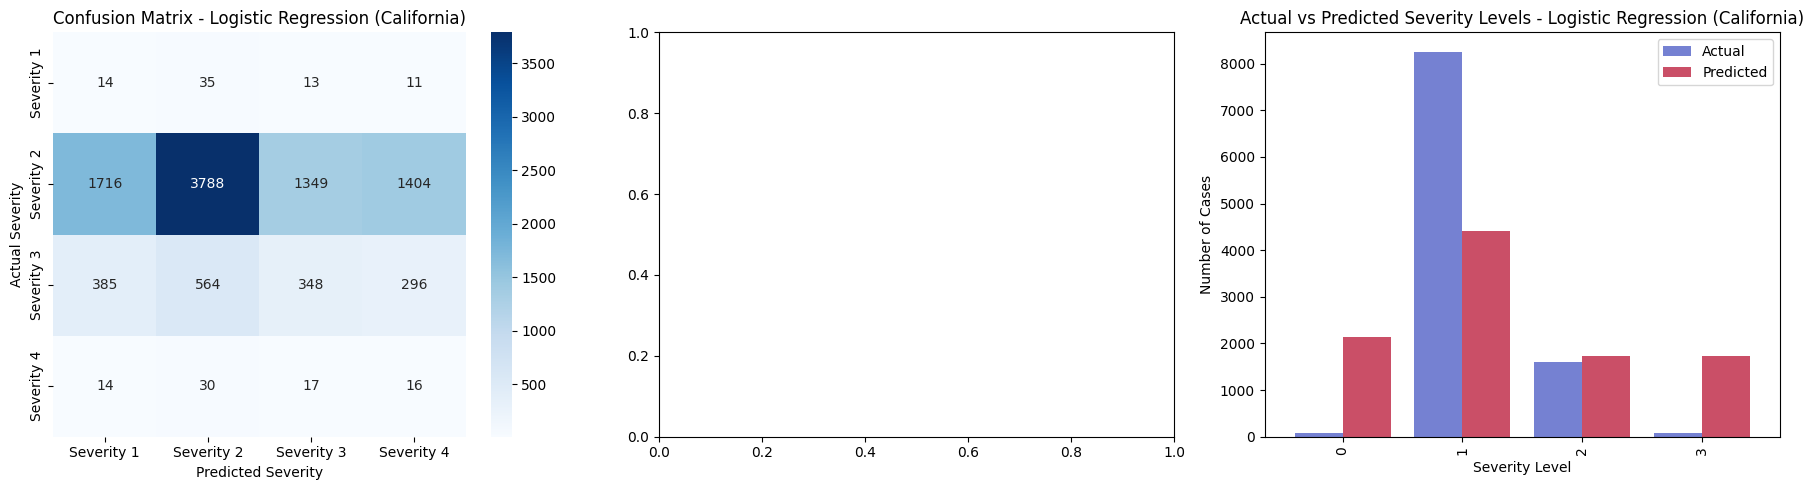

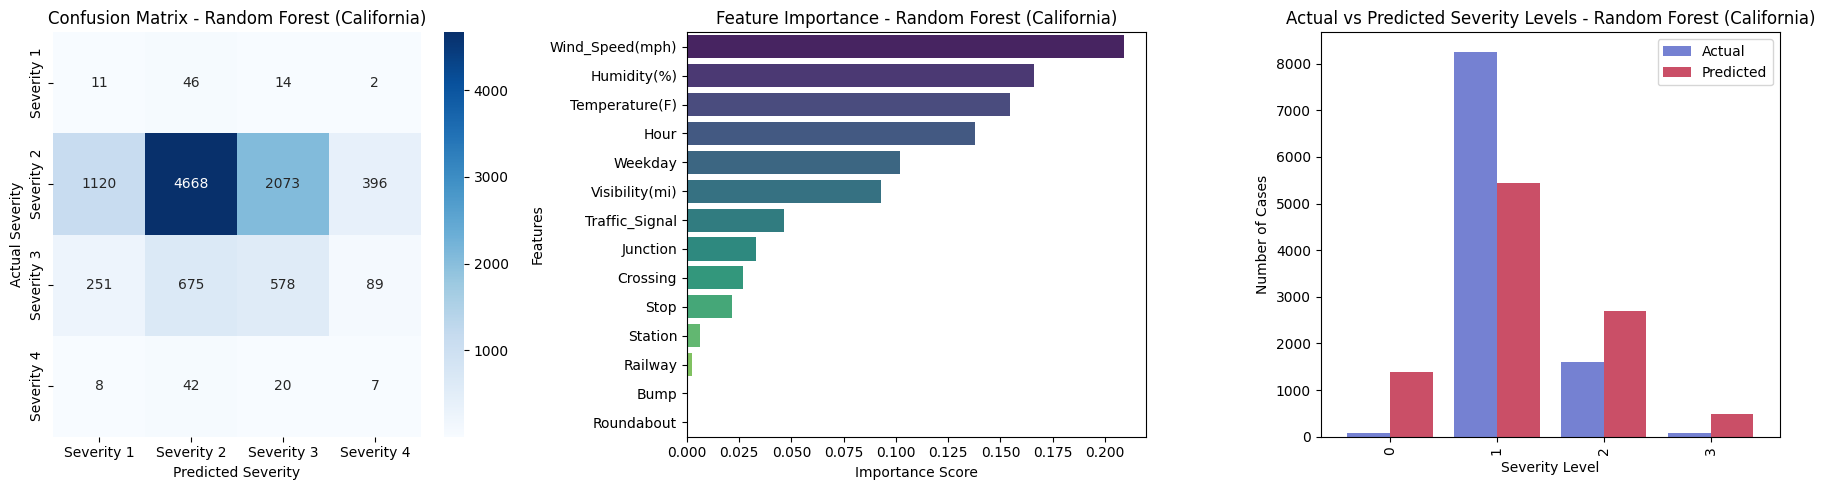

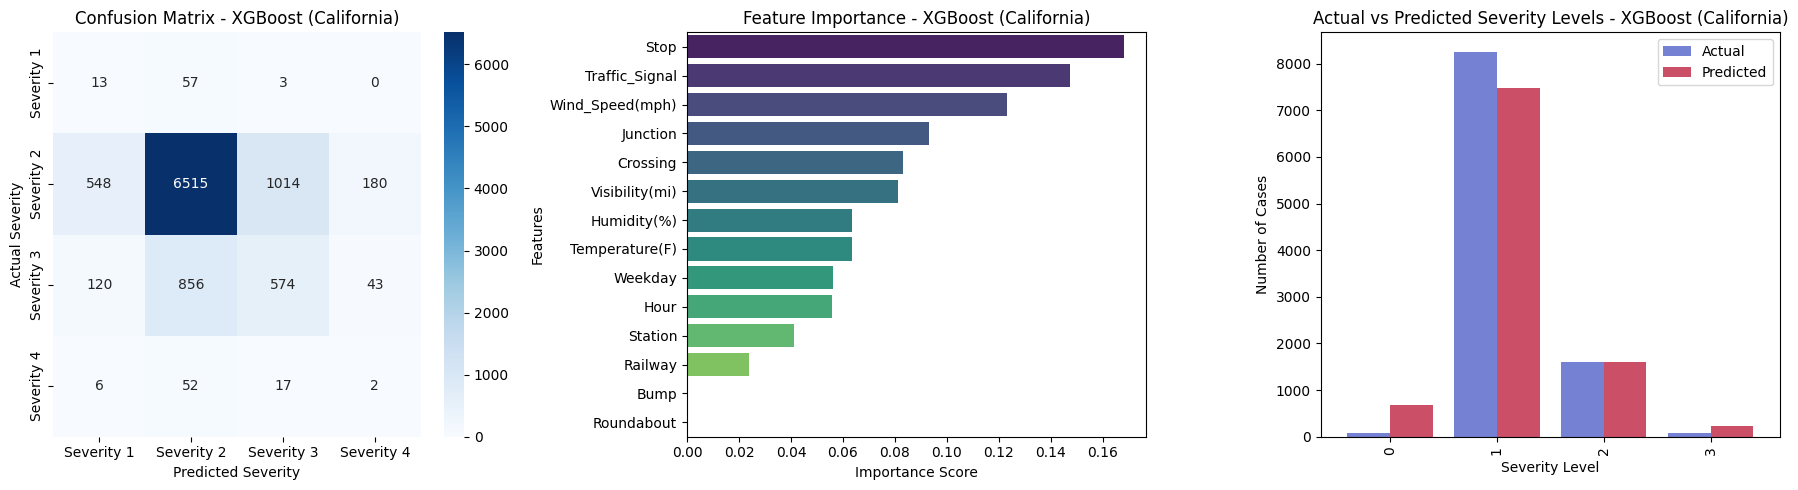


Model Comparison Results:
              Model  Accuracy  Macro Precision  Macro Recall  Weighted F1-score
Logistic Regression    0.4166         0.268735      0.269198           0.527195
      Random Forest    0.5264         0.274216      0.292442           0.606519
            XGBoost    0.7104         0.313942      0.338353           0.741150



Prediction for Florida:


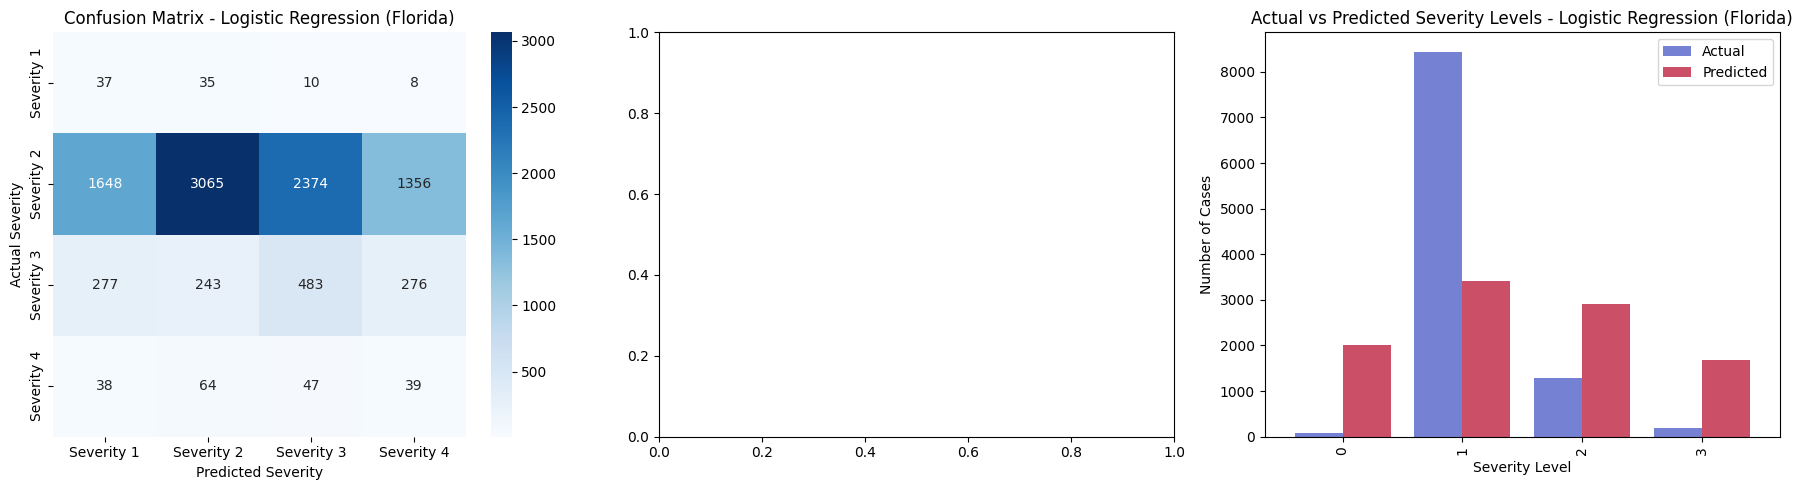

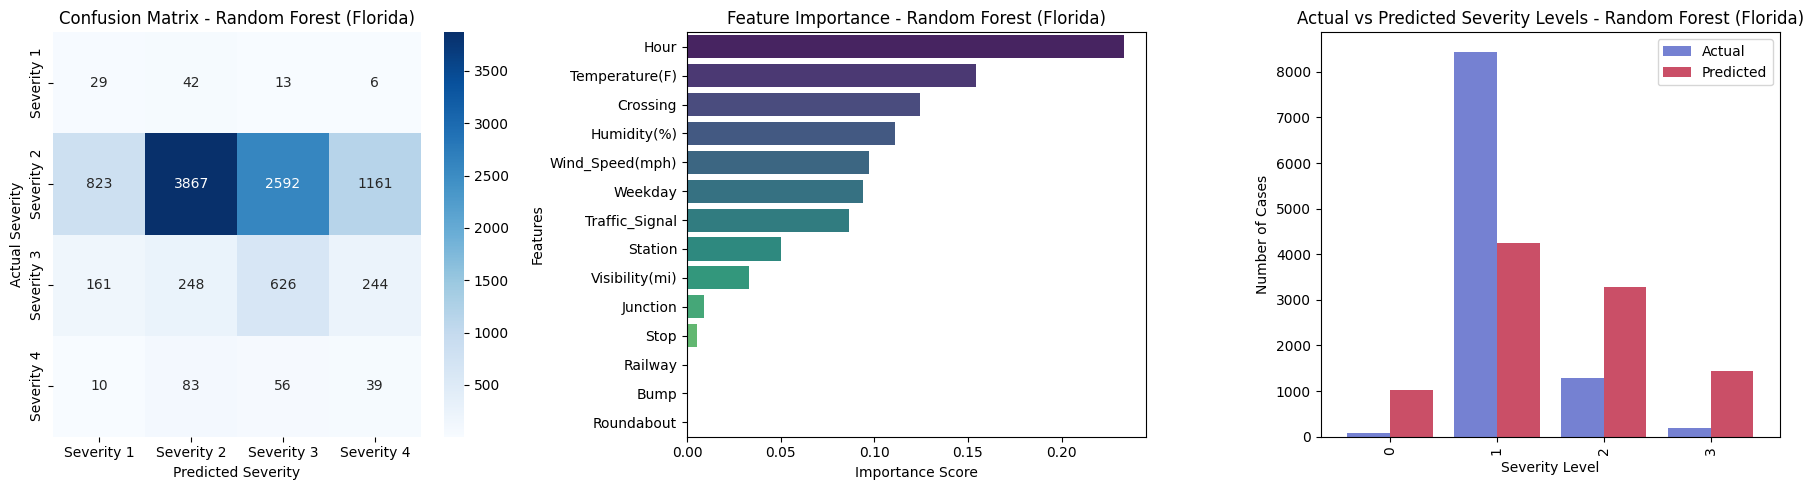

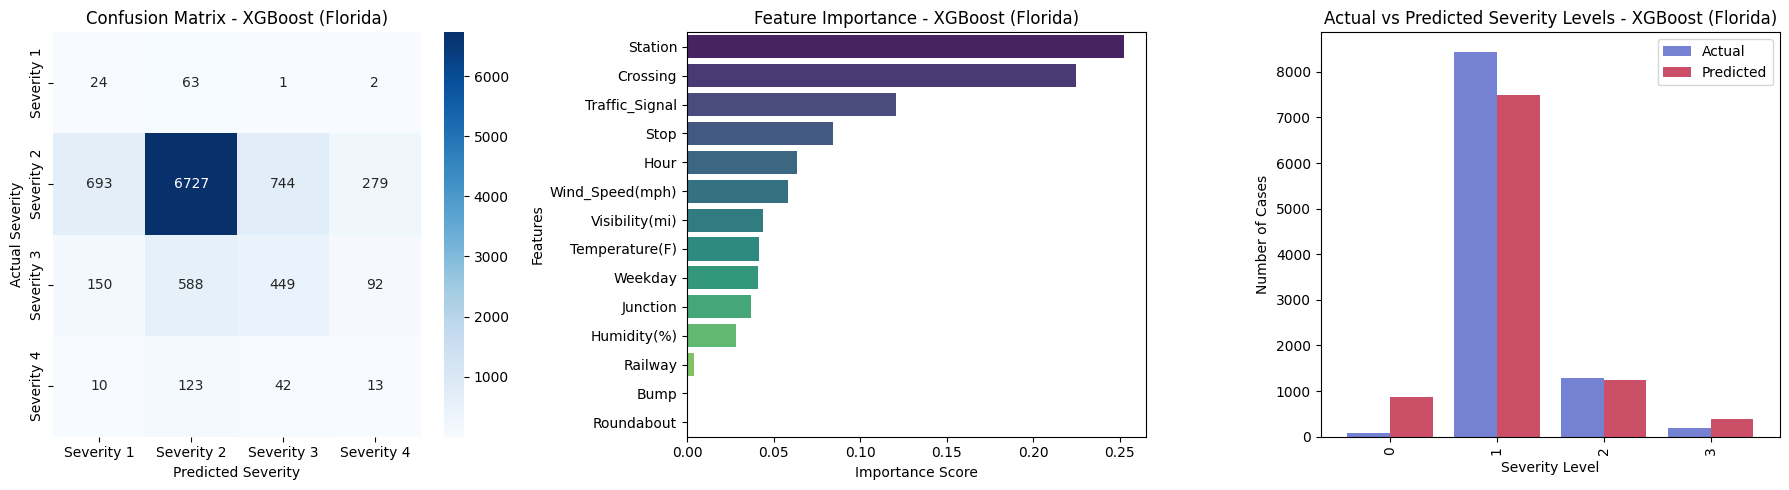


Model Comparison Results:
              Model  Accuracy  Macro Precision  Macro Recall  Weighted F1-score
Logistic Regression    0.3624         0.276775      0.339805           0.467326
      Random Forest    0.4561         0.289430      0.369282           0.551282
            XGBoost    0.7213         0.330282      0.370906           0.759410




In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

def train_model(model, X_train, y_train, X_test):
    """Train the model and return predictions."""
    model.fit(X_train, y_train)
    return model.predict(X_test), model


def evaluate_model(model_name, y_test, y_pred):
    """Generate classification report and return dictionary of results."""
    report = classification_report(y_test, y_pred, output_dict=True)
    return {
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Macro Precision": report["macro avg"]["precision"],
        "Macro Recall": report["macro avg"]["recall"],
        "Weighted F1-score": report["weighted avg"]["f1-score"]
    }


def plot_model_results(y_test, y_pred, feature_importances, feature_names, model_name, state_name):
    """
    Plots confusion matrix, feature importance, and actual vs predicted bar chart side by side.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    severity_levels = ["Severity 1", "Severity 2", "Severity 3", "Severity 4"]

    # Count actual vs predicted severity distribution
    actual_counts = pd.Series(y_test).value_counts().sort_index()
    predicted_counts = pd.Series(y_pred).value_counts().sort_index()
    df_combined = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts}).fillna(0)

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    #Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=severity_levels, yticklabels=severity_levels, ax=axes[0])
    axes[0].set_xlabel("Predicted Severity")
    axes[0].set_ylabel("Actual Severity")
    axes[0].set_title(f"Confusion Matrix - {model_name} ({state_name})")

    #Plot Feature Importance (only for models with feature importances)
    if feature_importances is not None:
        feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        feature_df = feature_df.sort_values(by='Importance', ascending=False)

        sns.barplot(x='Importance', y='Feature', data=feature_df, palette="viridis", ax=axes[1])
        axes[1].set_title(f"Feature Importance - {model_name} ({state_name})")
        axes[1].set_xlabel("Importance Score")
        axes[1].set_ylabel("Features")

    #Plot Actual vs Predicted Bar Chart
    df_combined.plot(kind="bar", colormap="coolwarm", alpha=0.7, width=0.8, ax=axes[2])
    axes[2].set_title(f"Actual vs Predicted Severity Levels - {model_name} ({state_name})")
    axes[2].set_xlabel("Severity Level")
    axes[2].set_ylabel("Number of Cases")
    axes[2].legend(["Actual", "Predicted"])

    # Show the plots
    plt.tight_layout()
    plt.show()


def compare_models(data, state_name):
    """
    Trains and compares Logistic Regression, Random Forest, and XGBoost on accident severity classification.
    Generates classification reports and visualizations.
    """

    #Extract time-based features
    data['Hour'] = data['Start_Time'].dt.hour
    data['Weekday'] = data['Start_Time'].dt.weekday

    #Define road condition features
    road_conditions = ["Bump", "Crossing", "Junction", "Railway", "Roundabout", "Station", "Stop", "Traffic_Signal"]
    
    #Keep only relevant features
    selected_features = ["Hour", "Weekday", "Temperature(F)", "Humidity(%)", "Visibility(mi)", "Wind_Speed(mph)"] + road_conditions
    selected_features = [col for col in selected_features if col in data.columns]  # Keep only available columns
    data = data[selected_features + ["Severity"]].copy()

    #Convert boolean values to integers (True ➝ 1, False ➝ 0)
    for col in road_conditions:
        if col in data.columns:
            data[col] = data[col].astype(int)

    #Drop NaN values
    data = data.dropna()

    #Select a random subset of 50,000 rows
    data_sample = data.sample(n=min(50000, len(data)), random_state=42)

    #Define features (X) and target variable (y)
    X = data_sample[selected_features]
    y = data_sample['Severity'] - 1  # XGBoost expects labels to start from 0

    #Train-test split (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    #Apply SMOTE to balance classes
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    #Standardize features
    scaler = StandardScaler()
    X_train_res = scaler.fit_transform(X_train_res)
    X_test = scaler.transform(X_test)

    #Define Models
    models = {
        "Logistic Regression": LogisticRegression(solver='saga', max_iter=500, class_weight='balanced'),
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42, eval_metric='mlogloss')
    }

    #Train models and evaluate results
    results = []
    for model_name, model in models.items():
        y_pred, trained_model = train_model(model, X_train_res, y_train_res, X_test)
        results.append(evaluate_model(model_name, y_test, y_pred))
        plot_model_results(y_test, y_pred, trained_model.feature_importances_ if hasattr(trained_model, "feature_importances_") else None, X.columns, model_name, state_name)

    #Convert results into a DataFrame
    df_results = pd.DataFrame(results)

    #Display results table
    print("\nModel Comparison Results:")
    print(df_results.to_string(index=False))


#Running the comparison for each state
state_list_ids = {
    "New York": "1mtOvSHslo4_Hll-PCqBblPticARKV4jd",
    "California": "1CHspEwcsJZ5ZC3zZq9BPf4lTMNQJQOPQ",
    "Florida": "1hqsDRaN3pbCAdv1w7atr5nJiBE0Qgihw",
}

#Loop through each state and process data
for state, file_id in state_list_ids.items():
    print(f"\nPrediction for {state}:")
    state_data = load_data(file_id)  # Load data for the state
    compare_models(state_data, state)
    print("\n")
